In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import regex
from sklearn.neighbors import KDTree
from scipy.spatial import cKDTree
from scipy.integrate import simpson, trapezoid
import warnings, os

In [42]:
class Trajectory:
    '''
    Class to parse, manipulate and plot the lammps-trajectory objects.
    Takes one input argument 'file' which is the filepath of the .lammpstrj file to initialize
    - added functionality to also parse gromac trajectory .gro files.
    - TODO:: parse atom count from file instead of hardcode dummy -> only for gromac 
    '''

    def __init__(self, file, format='lammpstrj', scaled=1):
        '''
        init of trajectory class
        :param file: file path to get the trajectory from
        :param format: default "lammpstrj", optional "gromac" or "XDATCAR"
                NOTE: if you want to add more formats make sure to include the apropriate format_to_np() parsers 
                with the same output format as the included ones.
        '''
        self.file = file
        if format == 'lammpstrj':
            self.trajectory, self.box_dim, self.n_atoms = self.lammpstrj_to_np(scaled)
        if format == 'lammps_data':
            self.trajectory, self.box_dim, self.n_atoms = self.lammps_data_to_np(scaled)
        if format == 'gromac':
               self.trajectory, self.box_dim = self.gromac_to_np()
        if format == 'XDATCAR':
            self.trajectory, self.box_dim = self.xdatcar_to_np()
        self.n_snapshots = len(self.box_dim)
        self.box_size = 0
        self.get_box_size()
        
        if scaled == 0:
            self.scale_to_lammps(scaled)
            

        
        self.s1, self.s2 = self.split_species()
        self.indexlist = 0
        self.distance = 0
        self.ion_distance = 0

    def xdatcar_to_np(self):
        '''
        Method to parse vasp-xdatcar style formated trajectories
        :param file: string giving the XDATCAR file path
        :return: returns n_dim np array with the trajectory at each snapshot and a list of the current box dimensions
        ''' 

        snap_count = 0
        snap_lines = []
        n_atoms = 0

        with open(self.file) as f:
            for line_number, line in enumerate(f):

                if regex.match("Direct", line):
                    snap_count += 1
                    snap_lines.append(line_number + 1)
                    #print(snap_count)    
                if line_number == 6:
                    n_atoms = sum([int(i) for i in line.split()])
                    next

        atom_list = np.zeros((snap_count, n_atoms , 5))
        ind_list = [np.zeros(0) for _ in range(snap_count)]
        box_ind_list = [np.zeros(0) for _ in range(snap_count)]
        box_list = np.zeros((snap_count, 3, 3))
        box_lines = [i - 6 for i in snap_lines]
        for i in range(snap_count):
            ind_list[i] = np.arange(snap_lines[i], snap_lines[i] + n_atoms )
            box_ind_list[i] = np.arange(box_lines[i], box_lines[i] +3)



        snap_count = 0
        line_count = 0

        with open(self.file) as f:
            for line_number, line in enumerate(f):

                if any(line_number == box_ind_list[snap_count]):
                    #print(line.split())
                    box_list[snap_count, :]=np.array([float(i) for i in line.split()])

                if any(line_number == ind_list[snap_count]):
                    atom_list[snap_count, line_count, 2:] = np.array([float(i) for i in line.split()])
                    ### need way to distinguish O and H's in Vasps XDATCAR file
                    print(atom_list[snap_count, line_count, :])

                    line_count += 1
                if line_count == n_atoms:
                    snap_count += 1
                    line_count = 0
                    #print(snap_count)
                if line_number >= ind_list[-1][-1]:
                    break    
        return atom_list, box_list
    
    def lammps_data_to_np(self, scal=1):
        '''
        Method to parse lammps data-format trajectories
        :return: returns n_dim np array with the trajectory at each snapshot and a list of the current box dimensions

        NOTE: only works for single time-frame for now -> todo make it general, less hacky 
        '''

        ###find the number of snapshots we have and safe the corresponding line
        ###also finds the number of atoms to initialize n_dim array later
        particle_counter = 0
        n_atoms = []
        box_dim = []
        atom_list = []


        with open(self.file) as f:
            
            for snap, line in enumerate(f):


                if regex.match('[0-9]+ atoms', line):
                    print(line)
                    n_atoms.append(int(line.split()[0]))
                    print(n_atoms)
                    n_atoms = n_atoms[-1]
                    



                if snap > 4 and snap < 8:
                    box_dim.append(np.array([float(i) for i in line.split()[:2]]))
                    
                #todo: fix the regexp.match issue between windows and linux
                #n_atoms=384
                if snap > 16 and snap < 16 + n_atoms + 1:
                    atom_list.append(np.array([float(i) for i in line.split()[:5]]))


        # transform list of box information into useful square data format.

        temp = box_dim
        box_dim = []                             
        box_dim.append(np.stack(temp))
        temp = atom_list
        atom_list = np.stack(temp).reshape((1, 384, 5))
          
        print(atom_list.shape)

        ##renormalize coordinates using pbc if neccesary -> only if data is in scaled lammps coordinates [0,1]
        if scal == 1:


            temp = atom_list[:, :, 2:] >= 1
            atom_list[:, :, 2:][temp] = atom_list[:, :, 2:][temp] - 1
            temp = atom_list[:, :, 2:] < 0
            atom_list[:, :, 2:][temp] = atom_list[:, :, 2:][temp] + 1


        print(box_dim)
        return atom_list, box_dim, n_atoms



    def gromac_to_np(self):
        '''
        Method to parse gromac style formated trajectories
        :param file: string giving the lammpstrj file path
        :return: returns n_dim np array with the trajectory at each snapshot and a list of the current box dimensions
        '''


        snap_count = 0
        snap_lines = []
        n_atoms = 384   ###TODO: fix hard-code at some point

        with open(self.file) as f:
            for snap, line in enumerate(f):
                if regex.match('Generated', line.split()[0]):
                    snap_lines.append(snap + 2)
                    snap_count += 1

            atom_list = np.zeros((snap_count, n_atoms , 5))
            ind_list = [np.zeros(0) for _ in range(snap_count)]

            for i in range(snap_count):
                ind_list[i] = np.arange(snap_lines[i], snap_lines[i] + n_atoms )

        #print(ind_list)
        snap_count = 0
        line_count = 0
        box_dim = []
        with open(self.file) as f:
            for line_number, line in enumerate(f):

                if len(line.split()[:]) == 3:
                    box_dim.append(np.array([float(i) for i in line.split()[:]]))

                if any(line_number == ind_list[snap_count]):
                    if regex.match('OW1', line.split()[1]):
                        atom_list[snap_count, line_count, 1] = 1
                    if regex.match('HW2', line.split()[1]):
                        atom_list[snap_count, line_count, 1] = 2
                    if regex.match('HW3', line.split()[1]):
                        atom_list[snap_count, line_count, 1] = 2

                    atom_list[snap_count, line_count, 2:] = np.array([float(i) for i in line.split()[-3:]])
                    line_count += 1
                if line_count == n_atoms:
                    snap_count += 1
                    line_count = 0
                    print(snap_count)
                if line_number >= ind_list[-1][-1]:
                    break
        return atom_list, box_dim


    def lammpstrj_to_np(self, scal=1):
        '''
        function to parse lammstrj format files to extract trajectories and return them in useable numpy data structures.
        :param file: string giving the lammpstrj file path
        :return: returns n_dim np array with the trajectory at each snapshot
            '''

        # might be usefull to know total no. of lines later on
        n_lines = sum(1 for line in open(self.file))

        ###find the number of snapshots we have and safe the corresponding line
        ###also finds the number of atoms to initialize n_dim array later
        snap_count = 0
        box_lines = 0
        n_atoms = []
        snap_lines = []
        box_dim = []
        

        with open(self.file) as f:
            for snap, line in enumerate(f):
                if regex.match('ITEM: ATOMS id', line):
                    snap_lines.append(snap + 2)
                    snap_count += 1
                if regex.match('ITEM: NUMBER OF ATOMS', line):

                    n_atoms.append(int(next(f))) 
                if box_lines > 0:
                    box_lines -= 1
                    box_dim.append(np.array([float(i) for i in line.split()]))
                if regex.match('ITEM: BOX BOUNDS', line):
                    box_lines = 3
            # print(snap_count, snap_lines, n_atoms)
        
        #super hacky fix should work for now but todo:better solution
        n_atoms = n_atoms[0]
    
        # transform list of box information into useful square data format.
        n_box = len(box_dim)
        temp = box_dim
        box_dim = []
        for split in range(int(n_box / 3)):
            box_dim.append(np.stack((temp[(split * 3): (split * 3 + 3)])))

        for key, line in enumerate(snap_lines):
            snap_lines[key] = line + key
        ### initialize np.arry of size (no of timesteps, no of atoms, 3d+id+species)

        atom_list = np.zeros((snap_count, n_atoms, 5))
        ind_list = [np.zeros(0) for _ in range(snap_count)]

        for i in range(snap_count):
            ind_list[i] = np.arange(snap_lines[i], snap_lines[i] + n_atoms)
        # print(ind_list)
        snap_count = 0
        line_count = 0
        with open(self.file) as f:
            for line_number, line in enumerate(f):

                # if line_number in ind_list[snap_count]:
                if any(line_number == ind_list[snap_count]):
                    atom_list[snap_count, line_count, :] = np.array([float(i) for i in line.split()])
                    line_count += 1
                if line_count == n_atoms:
                    snap_count += 1
                    line_count = 0
                    print("Processing Snapshot:" + str(snap_count))
                if line_number >= ind_list[-1][-1]:
                    break
            for line in f:
                pass
            
        ##renormalize coordinates using pbc if neccesary    
        if scal == 1:
        
        
            temp = atom_list[:, :, 2:] >= 1
            atom_list[:, :, 2:][temp] = atom_list[:, :, 2:][temp] - 1
            temp = atom_list[:, :, 2:] < 0
            atom_list[:, :, 2:][temp] = atom_list[:, :, 2:][temp] + 1
            
            
        return atom_list, box_dim, n_atoms
    
    
    def scale_to_lammps(self, scal):
        for i in range(len(self.box_dim)):
                self.trajectory[i, :, 2] /= self.box_size[i][0]
                self.trajectory[i, :, 3] /= self.box_size[i][1]
                self.trajectory[i, :, 4] /= self.box_size[i][2]
        
        if scal == 0:
            temp = self.trajectory[:, :, 2:] >= 1
            self.trajectory[:, :, 2:][temp] = self.trajectory[:, :, 2:][temp] - 1
            temp = self.trajectory[:, :, 2:] < 0
            self.trajectory[:, :, 2:][temp] = self.trajectory[:, :, 2:][temp] + 1


    def get_box_size(self):
        '''
        function to determine the actual box size given the box_dimensions extracted from the lammpstrj file
        :return: list of box_size - lengths - (x, y, z) for each snapshot.
        '''

        self.box_size = [None] * self.n_snapshots

        for i in range(self.n_snapshots):
            self.box_size[i] = abs(self.box_dim[i][:, 0] - self.box_dim[i][:, 1])


    def split_species(self):
        '''
        routine to split a lammpstrj which is formated as a np.ndim array of the form (n_steps, n_particles, n_cols=5)
        into its seperate particles (assuming Water-Molecules)
        :return out_1, out_2: two output lists of 2d numpy arrays, one for each species
        '''

        n_snap, n_row, n_col = self.trajectory.shape

        out_1 = [np.zeros(0) for _ in range(n_snap)]
        out_2 = [np.zeros(0) for _ in range(n_snap)]

        for i in range(n_snap):
            out_1[i] = (self.trajectory[i, np.where(self.trajectory[i, :, 1] == 1), :]).reshape(-1, 5)
            out_2[i] = (self.trajectory[i, np.where(self.trajectory[i, :, 1] == 2), :]).reshape(-1, 5)

        return out_1, out_2

    def get_neighbour_KDT(self, species_1=None, species_2=None, mode='normal', snapshot=0):
        '''
        Routin using sklearns implementation of the KDTree datastructure for quick nearestneighbour search in O(log(n))
        compared to the naive O(N) approach
        :param species_1: 2D numpy array of the positions of particles from species1 (n_row, (index, species, x, y, z))
        :param species_2: 2D numpy array of the positions of particles from species2 (n_row, (index, species, x, y, z))
        :param mode: sets the handling of boundary conditions with default 'normal' meaning no boundary condition
                    optional mode ['pbc']
        :param snapshot: specifies which snapshot we are looking at, default value is 0
        :return: ind_out np.array of the nearest neighbour indices of species1 found in species2, dist_out np.array of
                the euclidean distance
        '''

        #workaround to set instance atributes as default argument
        if species_1 is None:
            species_1 = self.s1 
        if species_2 is None:
            species_2 = self.s2 
        #if species_1 or species_2 == 0:
            #raise ValueError('set self.s1 or self.s2 first or pass required arguments')
        try:
            #print(species_1.shape)
            if mode == 'normal':
                tree = cKDTree(data=species_2[:, 2:] * self.box_size[snapshot], leafsize=species_2.shape[0])
            if mode == 'pbc':
                tree = cKDTree(data=species_2[:, 2:] * self.box_size[snapshot],
                               leafsize=species_2.shape[0], boxsize=self.box_size[snapshot])

            n_query = species_1.shape[0]
            ind_out = np.zeros(n_query)
            dist_out = np.zeros(n_query)
            for i in range(n_query):
                dist_out[i], ind_out[i] = tree.query((species_1[i, 2:] * self.box_size[snapshot]).reshape(1, -1), k=1)
                
        except (AttributeError, TypeError) as error:

            print("Atribute Error occured(recieved list instead of numpy array) using first element of list instead")
            species_1 = species_1[snapshot] 
            species_2 = species_2[snapshot] 

            if mode == 'normal':
                tree = cKDTree(data=species_2[:, 2:] * (self.box_size[snapshot]).reshape(1, -1), leafsize=species_2.shape[0])
            if mode == 'pbc':
                tree = cKDTree(data=species_2[:, 2:] * (self.box_size[snapshot]).reshape(1, -1), leafsize=species_2.shape[0], boxsize=self.box_size[snapshot])

            n_query = species_1.shape[0]
            ind_out = np.zeros(n_query)
            dist_out = np.zeros(n_query)
            for i in range(n_query):
                dist_out[i], ind_out[i] = tree.query((species_1[i, 2:]).reshape(1, -1) * (self.box_size[snapshot]).reshape(1, -1), k=1)

        return ind_out, dist_out

    def get_neighbour_naive(self, species_1=None, species_2=None, mode='normal', snapshot=0):
        '''
        Naive approach in calculating the nearest neighbour in linear time O(N) no optimizations done!
        :param species_1: 2D numpy array of the positions of particles from species1 (n_row, (index, species, x, y, z))
        :param species_2: 2D numpy array of the positions of particles from species2 (n_row, (index, species, x, y, z))
        :param mode: sets the handling of boundary conditions with default 'normal' meaning no boundary condition
                    optional mode ['pbc']
        :param snapshot: specifies which snapshot we are looking at, default value is 0
        :return: ind_out np.array of the nearest neighbour indices of species1 found in species2, dist_out np.array of
                the euclidean distance
        '''

        def get_distance(x, y, mode='normal', img=snapshot):
            '''
            wraper for np norm function to get euclidean metric
            :param x:
            :param y:
            :param mode: sets the mode for distance calculation
            :param img: specifies the image we are looking at, used to get the correct box size for PBC
            :return:
            '''

            if mode == 'normal':
                return np.linalg.norm(x-y)
            if mode == 'pbc':
                box = self.box_size[img]
                dist = x - y

                if dist[0] >= (box[0] / 2):
                    dist[0] -= box[0]
                if dist[0] < (-box[0] / 2):
                    dist[0] += box[0]

                if dist[1] >= (box[1] / 2):
                    dist[1] -= box[1]
                if dist[1] < (-box[1] / 2):
                    dist[1] += box[1]

                if dist[2] >= (box[2] / 2):
                    dist[2] -= box[2]
                if dist[2] < (-box[2] / 2):
                    dist[2] += box[2]

                return np.sqrt(np.sum(dist**2))
            else:
                raise ValueError(f'mode {mode} unknown please use either \'normal\' or \'pbc\'')

        if species_1 is None:
            species_1 = self.s1 * self.box_size
        if species_2 is None:
            species_2 = self.s2 * self.box_size
        try:
            n_row_1 = species_1.shape[0]
            n_row_2 = species_2.shape[0]

            distance_matrix = np.zeros((n_row_1, n_row_2))
            distances = np.zeros(n_row_1)
            index = np.zeros(n_row_1, dtype='int32')

            for H in range(n_row_1):
                for O in range(n_row_2):
                    distance_matrix[H, O] = get_distance(species_1[H, 2:], species_2[O, 2:], mode)

                index[H] = np.argmin(distance_matrix[H, :])
                distances[H] = distance_matrix[H, index[H]]

        except AttributeError:

            print("Atribute Error occured(recieved list instead of numpy array) using indexed element of list instead")
            species_1 = species_1[snapshot] * self.box_size[snapshot]
            species_2 = species_2[snapshot] * self.box_size[snapshot]
            n_row_1 = species_1.shape[0]
            n_row_2 = species_2.shape[0]

            distance_matrix = np.zeros((n_row_1, n_row_2))
            distances = np.zeros(n_row_1)
            index = np.zeros(n_row_1, dtype='int32')

            for H in range(n_row_1):
                for O in range(n_row_2):
                    distance_matrix[H, O] = get_distance(species_1[H, 2:], species_2[O, 2:], mode)

                index[H] = np.argmin(distance_matrix[H, :])
                #print(index[H], H)
                distances[H] = distance_matrix[H, index[H]]

        return index, distances

    def get_ion_distance(self):
        '''
        Method to calculate the euclidean distance between the two ions at each timestep, based on the
        distance of the OH- , H3O+ Oxygen Atoms. 
        :return: array [n_snap, (x1, y1, z1, x2, y2, z2, distance)]
        '''
        
        #note -> find solution to not copy get_distance function code into each method 
        #-> maybe make it a method by itselfe
        def get_distance(x, y, mode='pbc'):
            '''
            wraper for np norm function to get euclidean metric
            :param x:
            :param y:
            :param mode: sets the mode for distance calculation
            :param img: specifies the image we are looking at, used to get the correct box size for PBC
            :return:
            '''

            if mode == 'normal':
                return np.linalg.norm(x-y)
            if mode == 'pbc':
                box = [1, 1, 1] ##using scaled lammps coordinates
                dist = x - y
                if dist[0] >= (box[0] / 2):
                    dist[0] -= box[0]
                if dist[0] < (-box[0] / 2):
                    dist[0] += box[0]

                if dist[1] >= (box[1] / 2):
                    dist[1] -= box[1]
                if dist[1] < (-box[1] / 2):
                    dist[1] += box[1]

                if dist[2] >= (box[2] / 2):
                    dist[2] -= box[2]
                if dist[2] < (-box[2] / 2):
                    dist[2] += box[2]

                return np.sqrt(np.sum(dist**2))
            else:
                raise ValueError(f'mode {mode} unknown please use either \'normal\' or \'pbc\'')

        
        self.ion_distance = np.zeros((self.n_snapshots, 8))
        #OH_id = None
        #H3O_id = None
        #step 1 get particle ids of the two ion oxygens
            #step 1.1 detect ions 

        for i in range(self.n_snapshots): 
            
            OH_id = None
            H3O_id = None
            
            #note: find nearest O atom for each H atom
            indexlist_group, _ = self.get_neighbour_KDT(species_1=self.s1[i], 
                                                        species_2=self.s2[i], mode="pbc", snapshot=0) 

            #note: find he  number of  occourence of O atoms for which it is the nearest to an H atom. 
            #-> for H2O each O atom will count twice, for each H3O+ each O atom will count 3 times and so on.
            temp = [None]*self.s2[i].shape[0]
            for O_atom in  range(self.s2[i].shape[0]): 
                temp[O_atom] = np.append(np.argwhere(indexlist_group == O_atom), O_atom)

            #print(temp)
            #check how often each O atom counted -> molecules formation  OH- = 1 time H3O+  3 Times  H2O 2 times. 
            for ind, _list in enumerate(temp):
                #print(list)

                if len(_list) == 2:
                    OH_id = _list[-1]
                if len(_list) == 4:
                    H3O_id = _list[-1]
                else:
                    pass

            try:
                if OH_id is None or H3O_id is None:
                    raise ValueError("Either OH or H3O index was not found")




                temp = get_distance(self.trajectory[i, OH_id, 2:], self.trajectory[i, H3O_id, 2:])

                self.ion_distance[i, :] = np.array([i] + self.trajectory[i, OH_id, 2:].tolist() \
                                                      + self.trajectory[i, H3O_id, 2:].tolist() + [temp])
            except ValueError:
                self.ion_distance[i, :] = np.array([i] + [0, 0, 0] \
                                                      + [0, 0, 0] + [0])

        return self.ion_distance
    
    
    def get_hydrogen_bonds(self):
        
        
        return None
    
    
    def get_water_hist(self, index_list=None):
        '''
        Quick Wraperfunction for pyplot OOP APi to draw a histogram of H-Bond distribution
        :param index_list: list of indexes for NN of the H-Atoms
        :return: Plot of the Histogram
        '''

        if index_list is None:
            index_list = self.indexlist
        #if index_list == 0:
            #raise ValueError('set self.indexlist first or pass required arguments')

        fig = plt.figure()
        ax1 = fig.add_subplot(1, 1, 1)

        ax1.yaxis.grid(alpha=0.7, linestyle="dashed", linewidth=1.5)
        ax1.set_ylabel("number of H Bonds")
        ax1.set_xlabel("index of O Atom")
        ax1.set_title("Histogram of Water Species")
        ax1.xaxis.set_ticks_position('none')
        ax1.yaxis.set_ticks_position('none')
        h, _, _ = ax1.hist(index_list, bins=np.arange(min(index_list), max(index_list) + 1, 1),
                           histtype='bar', alpha=0.8, color="purple")
        plt.show()
        plt.hist(h, bins=np.arange(min(h), max(h) + 1, 1),
                 histtype='bar', alpha=0.8, color="purple", density=True)
        plt.xlabel('number of H bonds')
        plt.ylabel('frequency')
        plt.title('Distribution of H-Bonds')
        plt.show()
        return


    def get_displace(self, snapshot = 0, id = None, distance=0.05, eps=0.01, dp_factor = 0.99,
                     path=None, num_traj=None):
        '''
        :param snapshot: index of the snapshot at which the displacement should happen
        :param id: id of the reference oxygen if none is given one will be picked at random
        :param distance: distance to where we want to displace to (searching for an oxygen
         particle in that radius)
        :param eps: dr at which we still accept an oxygen
        :param dp_factor: factor with which the hydrogens coordinates differ to its reference, 
                NOTE will get replaced by a collision detection method 
        :param path: Optional path to safe the file in, otherwise it will be safed in the current directory
        :param name: Optional file name, otherwise it will be called "water.data"
        :param num_traj: Optional number of different trajectories to be generated
        :return: trajectory with one Oxygen removed and one Hydrogen displaced
        '''
            
            
        def get_distance(x, y, mode='pbc'):
            '''
            wraper for np norm function to get euclidean metric
            :param x:
            :param y:
            :param mode: sets the mode for distance calculation
            :param img: specifies the image we are looking at, used to get the correct box size for PBC
            :return:
            '''

            if mode == 'normal':
                return np.linalg.norm(x-y)
            if mode == 'pbc':
                box = [1, 1, 1] ##using scaled lammps coordinates
                dist = x - y
                if dist[0] >= (box[0] / 2):
                    dist[0] -= box[0]
                if dist[0] < (-box[0] / 2):
                    dist[0] += box[0]

                if dist[1] >= (box[1] / 2):
                    dist[1] -= box[1]
                if dist[1] < (-box[1] / 2):
                    dist[1] += box[1]

                if dist[2] >= (box[2] / 2):
                    dist[2] -= box[2]
                if dist[2] < (-box[2] / 2):
                    dist[2] += box[2]

                return np.sqrt(np.sum(dist**2))
            else:
                raise ValueError(f'mode {mode} unknown please use either \'normal\' or \'pbc\'')
                
        def get_displaced_H(H_displace, H_pair, reference_O):
            '''
            helper function to find the coordinates of the displaced H Atom by finding the midpoint between the Bondingatoms of
            the reference O atom and then mirroring this point in space, while making sure the distance between the displaced H 
            and the reference O is smaler then the distance fo the O to its closest bonding H
            '''
        
            minimum_distance = np.min([get_distance(H_pair[0], reference_O), get_distance(H_pair[1], reference_O)])
            midpoint = (H_pair[0] + H_pair[1]) / 2
            mid_vector = midpoint - reference_O
            
            
            new_H = midpoint - 2 * mid_vector
            while (get_distance(new_H, reference_O) < 1.1*minimum_distance) :
                new_H -= 0.05*mid_vector 
                if get_distance(new_H, reference_O) >= 1.2*minimum_distance:
                    return new_H
            return new_H
        
        
        if path is None:
            water_file = "water.data"
        else:
            water_file = path + "water.data"

            
        if num_traj is None:
            
            if id is None:
                id = np.random.randint(0, len(self.s2[0]))
            
            
            traj = self.trajectory[snapshot]
            O_list = self.s2[snapshot]
            H_list = self.s1[snapshot]
            O_list = O_list[:, 2:]
            H_list = H_list[:, 2:]
            reference_O = O_list[id, :]
            reference_H = H_list[np.argwhere(self.indexlist == id).reshape(-1), :]
            distances = []


            for i in range(len(O_list)):
                temp = get_distance(reference_O, O_list[i, :])
                
                if temp == 0.0:
                    continue 
                
                print(temp)
                
                

                if (temp <= (distance + eps)) and (temp >= (distance - eps)):
                    displace_H = H_list[np.argwhere(self.indexlist == i)[0], :]


                    ### displace the H towards the reference O
                    print("displace")
                    displace_H = get_displaced_H(displace_H, reference_H, reference_O)


                    #O_list = np.delete(O_list, i, axis=0) -> if we want to remove an O (not sure if we do?)

                    #update the hydrogen list with the new displaced coordinates
                    H_list[np.argwhere(self.indexlist == i)[0], :] = displace_H

                            ##renormalize coordinates using pbc if neccesary    
                    temp = H_list[:, :] >= 1
                    H_list[:, :][temp] = H_list[:, :][temp] - 1
                    temp = H_list[:, :] < 0
                    H_list[:, :][temp] = H_list[:, :][temp] + 1

                    with open(water_file, "a") as input_traj:
                        input_traj.write('translated LAMMPS data file via gromacsconf\n')
                        input_traj.write('\n')
                        input_traj.write(f'       {self.n_atoms}  atoms\n')
                        input_traj.write('           2  atom types\n')
                        input_traj.write('\n')
                        input_traj.write(f'   0.00000000       {self.box_size[snapshot][0]}       xlo xhi\n')
                        input_traj.write(f'   0.00000000       {self.box_size[snapshot][1]}       ylo yhi\n')
                        input_traj.write(f'   0.00000000       {self.box_size[snapshot][2]}       zlo zhi\n')
                        input_traj.write(f'   0.00000000       0.00000000       0.00000000      xy xz yz\n')
                        input_traj.write('\n')
                        input_traj.write(' Masses\n')
                        input_traj.write('\n')
                        input_traj.write('           1   1.00794005\n')
                        input_traj.write('           2   15.9994001\n')
                        input_traj.write('\n')
                        input_traj.write(' Atoms\n')
                        input_traj.write('\n')

                        for H_ind in range(H_list.shape[0]):
                            input_traj.write(f'{H_ind + 1} 1 {H_list[H_ind, 0]*self.box_size[snapshot][0]} {H_list[H_ind, 1]*self.box_size[snapshot][1]} {H_list[H_ind, 2]*self.box_size[snapshot][2]}')
                            input_traj.write('\n')
                        for O_ind in range(O_list.shape[0]):
                            input_traj.write(f'{O_ind + 1 + H_list.shape[0] } 2 {O_list[O_ind, 0]*self.box_size[snapshot][0]} {O_list[O_ind, 1]*self.box_size[snapshot][1]} {O_list[O_ind, 2]*self.box_size[snapshot][2]}')
                            input_traj.write('\n')


                    return print("trajectory saved as water.data")

                else:
                    distances.append(temp)
                    print("distance too far next O")
                
        if num_traj is not None:
            
            if isinstance(num_traj, int):
                pass
            else:
                num_traj = int(num_traj)
                warnings.warn("num_traj is not an integer, it will be converted. please check format")
                
            
            
            
            for copy in range(num_traj):
                
                if id is None:
                    id = np.random.randint(0, len(self.s2[0]))
            
            
                traj = self.trajectory[snapshot]
                O_list = self.s2[snapshot]
                H_list = self.s1[snapshot]
                O_list = O_list[:, 2:]
                H_list = H_list[:, 2:]
                reference_O = O_list[id, :]
                reference_H = H_list[np.argwhere(self.indexlist == id).reshape(-1), :]
                distances = []


                for i in range(len(O_list)):
                    temp = get_distance(reference_O, O_list[i, :])
                    
                    if temp == 0.0:
                        continue 
                    
                    print(temp)
                    


                    if (temp <= distance + eps) and (temp >= distance - eps):
                        displace_H = H_list[np.argwhere(self.indexlist == i)[0], :]


                        ### displace the H towards the reference O
                        print("displace")
                        displace_H = get_displaced_H(displace_H, reference_H, reference_O)


                        #O_list = np.delete(O_list, i, axis=0) -> if we want to remove an O (not sure if we do?)

                        #update the hydrogen list with the new displaced coordinates
                        H_list[np.argwhere(self.indexlist == i)[0], :] = displace_H

                        ##renormalize coordinates using pbc if neccesary    
                        temp = H_list[:, :] >= 1
                        H_list[:, :][temp] = H_list[:, :][temp] - 1
                        temp = H_list[:, :] < 0
                        H_list[:, :][temp] = H_list[:, :][temp] + 1
                        water_file = water_file + "_" + str(copy)
                        
                        with open(water_file, "a") as input_traj:
                            input_traj.write('translated LAMMPS data file via gromacsconf\n')
                            input_traj.write('\n')
                            input_traj.write(f'       {self.n_atoms}  atoms\n')
                            input_traj.write('           2  atom types\n')
                            input_traj.write('\n')
                            input_traj.write(f'   0.00000000       {self.box_size[snapshot][0]}       xlo xhi\n')
                            input_traj.write(f'   0.00000000       {self.box_size[snapshot][1]}       ylo yhi\n')
                            input_traj.write(f'   0.00000000       {self.box_size[snapshot][2]}       zlo zhi\n')
                            input_traj.write(f'   0.00000000       0.00000000       0.00000000      xy xz yz\n')
                            input_traj.write('\n')
                            input_traj.write(' Masses\n')
                            input_traj.write('\n')
                            input_traj.write('           1   1.00794005\n')
                            input_traj.write('           2   15.9994001\n')
                            input_traj.write('\n')
                            input_traj.write(' Atoms\n')
                            input_traj.write('\n')

                            for H_ind in range(H_list.shape[0]):
                                input_traj.write(f'{H_ind + 1} 1 {H_list[H_ind, 0]*self.box_size[snapshot][0]} {H_list[H_ind, 1]*self.box_size[snapshot][1]} {H_list[H_ind, 2]*self.box_size[snapshot][2]}')
                                input_traj.write('\n')
                            for O_ind in range(O_list.shape[0]):
                                input_traj.write(f'{O_ind + 1 + H_list.shape[0] } 2 {O_list[O_ind, 0]*self.box_size[snapshot][0]} {O_list[O_ind, 1]*self.box_size[snapshot][1]} {O_list[O_ind, 2]*self.box_size[snapshot][2]}')
                                input_traj.write('\n')


                        print(f"trajectory saved as water_{copy}.data")

                    else:
                        distances.append(temp)
                        print("distance too far next O")
    
    
    def cut_snapshot(self, snapshot=0, path=None):
        '''
        Method to remove a single time-frame from an entire trajectory for usage as an input for a new md run.
        :param snapshot: the frame at which point in time should be cut, default=0
        :param path: path to where the file should be saved to, default=None -> CWD
        '''
                    
        traj = self.trajectory[snapshot]
        O_list = self.s2[snapshot]
        H_list = self.s1[snapshot]
        O_list = O_list[:, 2:]
        H_list = H_list[:, 2:]
        
        if path is not None:
            water_file = path + "traj_cut_out.data"
        else:
            water_file = "traj_cut_out.data"

                        
        with open(water_file, "a") as input_traj:
            input_traj.write('translated LAMMPS data file via gromacsconf\n')
            input_traj.write('\n')
            input_traj.write(f'       {self.n_atoms}  atoms\n')
            input_traj.write('           2  atom types\n')
            input_traj.write('\n')
            input_traj.write(f'   0.00000000       {self.box_size[snapshot][0]}       xlo xhi\n')
            input_traj.write(f'   0.00000000       {self.box_size[snapshot][1]}       ylo yhi\n')
            input_traj.write(f'   0.00000000       {self.box_size[snapshot][2]}       zlo zhi\n')
            input_traj.write(f'   0.00000000       0.00000000       0.00000000      xy xz yz\n')
            input_traj.write('\n')
            input_traj.write(' Masses\n')
            input_traj.write('\n')
            input_traj.write('           1   1.00794005\n')
            input_traj.write('           2   15.9994001\n')
            input_traj.write('\n')
            input_traj.write(' Atoms\n')
            input_traj.write('\n')

            for H_ind in range(H_list.shape[0]):
                input_traj.write(f'{H_ind + 1} 1 {H_list[H_ind, 0]*self.box_size[snapshot][0]} {H_list[H_ind, 1]*self.box_size[snapshot][1]} {H_list[H_ind, 2]*self.box_size[snapshot][2]}')
                input_traj.write('\n')
            for O_ind in range(O_list.shape[0]):
                input_traj.write(f'{O_ind + 1 + H_list.shape[0] } 2 {O_list[O_ind, 0]*self.box_size[snapshot][0]} {O_list[O_ind, 1]*self.box_size[snapshot][1]} {O_list[O_ind, 2]*self.box_size[snapshot][2]}')
                input_traj.write('\n')


                        
                        
    def remove_atoms(self, N=1, snap=0, atom_id=None, format_out="lammps"):
        '''
        Method to remove molecules from a given trajectory. New trajectory will be safed as "reduced_water.format"
        in the current folder. For N=0 this can be used to simply change the format i.e lammps>XDATCAR
        :param N: number of atoms to remove
        :param snap: from which snapshot of the original trajectory are the molecules to be removed
        :param atom_id: default=None, takes an np.array of the oxygen which is to be removed with its matching 
                        hydrogens. If not passed atoms will be taken at random
        '''


        O_list = self.s2[snap]
        H_list = self.s1[snap]
        print(O_list.shape, H_list.shape)
        to_remove_H_ind = np.empty(0, dtype=int)
        to_remove_O_ind = np.empty(0, dtype=int)
        atom_id = np.random.choice(len(O_list), size=N, replace=False)

        NN_list, _ = self.get_neighbour_KDT(mode='pbc', snapshot=snap)
        NN_list = np.rint(NN_list).astype(int)

        for i in range(N):
            

            to_remove_H_ind = np.append(to_remove_H_ind, np.argwhere(NN_list == atom_id[i])) 
            to_remove_O_ind = np.append(to_remove_O_ind, NN_list[to_remove_H_ind])
            


            #remember axis=0 -> rows
        
        O_list = np.delete(O_list, to_remove_O_ind, axis=0)
        H_list = np.delete(H_list, to_remove_H_ind, axis=0)
        print(O_list.shape, H_list.shape)

        if format_out == "lammps":

            def write_lammpstrj(atoms, ts=0, snapshot=0):
                with open("reduced_water.lammpstrj", "w") as group_traj:
                    group_traj.write('ITEM: TIMESTEP\n')
                    group_traj.write(f'{snapshot * ts}\n')
                    group_traj.write("ITEM: NUMBER OF ATOMS\n")
                    group_traj.write(str(self.n_atoms-3*N)+"\n")
                    #group_traj.write("ITEM: BOX BOUNDS xy xz yz pp pp pp\n")
                    group_traj.write("ITEM: BOX BOUNDS pp pp pp\n")
                    for i in range(3):
                        temp = " ".join(map(str, self.box_dim[snapshot][i, :]))
                        group_traj.write(f'{temp}\n')

                    group_traj.write("ITEM: ATOMS id type xs ys zs\n")

                    for i in range(atoms.shape[0]):
                        temp = atoms[i, :]
                        temp = " ".join(map(str, temp))
                        group_traj.write(f'{temp}\n')

                return

            write_lammpstrj(np.vstack((O_list, H_list)), snapshot=snap)
            return

        elif format_out == "XDATCAR":
            def write_XDATCAR(atoms, ts=0, snapshot=0, n_O=O_list.shape[0], n_H=H_list.shape[0]):
                with open("reduced_XDATCAR", "w") as group_traj:
                    group_traj.write(f'unknown system\n')
                    group_traj.write(f'           1\n')
                    group_traj.write(f'    {np.round(self.box_size[snapshot][0], 6)}    0.000000    0.000000\n')
                    group_traj.write(f'     0.000000   {np.round(self.box_size[snapshot][1], 6)}    0.000000\n')
                    group_traj.write(f'     0.000000    0.000000   {np.round(self.box_size[snapshot][1], 6)}\n')
                    group_traj.write("    O    H\n")
                    group_traj.write(f'    {n_O}   {n_H}\n')
                    group_traj.write(f'Direct configuration=     1\n')
                    for i in range(atoms.shape[0]):
                        temp = atoms[i, 2:]
                        temp = " ".join(map(str, temp))
                        group_traj.write(f'{temp}\n')

                return
            write_XDATCAR(np.vstack((O_list, H_list)), snapshot=snap)
        
        
        
        

        elif format_out == "gromac":
            warnings.warn("Foarmat gromac currently not supported")
            return

        else:
            warnings.warn("not supported format_out please check documentation for viable formats")
            return

        

    def group_molecules(self, timestep=5000, path=None):
        '''
        method to group nearest neighbours back to molecules to track their trajectory in time
        :return: lammpstraj file readable by common MD visualizer like ovito
        '''

        if path is not None:
             new_traj = open(path+'grouped_water.lammpstrj', "w")
        else:
            new_traj = open('grouped_water.lammpstrj', "w")
            
        new_traj.close()


        def write_lammpstrj(molecules, ts=timestep, snapshot=0, _dir=path):
            if _dir is not None:
                with open(_dir+"grouped_water.lammpstrj", "a") as group_traj:
                    group_traj.write('ITEM: TIMESTEP\n')
                    group_traj.write(f'{snapshot * ts}\n')
                    group_traj.write("ITEM: NUMBER OF ATOMS\n")
                    group_traj.write(str(self.n_atoms)+"\n")
                    #group_traj.write("ITEM: BOX BOUNDS xy xz yz pp pp pp\n")
                    group_traj.write("ITEM: BOX BOUNDS pp pp pp\n")
                    for i in range(3):
                        temp = " ".join(map(str, self.box_dim[snapshot][i, :]))
                        group_traj.write(temp+"\n")

                    group_traj.write("ITEM: ATOMS id type xs ys zs\n")

                    for ind, list in enumerate(molecules):
                        if len(list) == 1:              #only O atom
                            for index in list:
                                temp = self.s2[snapshot][index, :]
                                temp[1] = 1
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                        if len(list) == 2:
                            for index in list[:-1]:     #index all the H atoms
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 2
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]         #write the O atom by hand
                            temp[1] = 2
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                        if len(list) == 3:
                            for index in list[:-1]:
                                #print(type(index))
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 3
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 3
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                        if len(list) == 4:
                            for index in list[:-1]:
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 4
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 4
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")

                        if len(list) == 5:
                            for index in list[:-1]:
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 5
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 5
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                return
            else:
                with open("grouped_water.lammpstrj", "a") as group_traj:
                    group_traj.write('ITEM: TIMESTEP\n')
                    group_traj.write(f'{snapshot * ts}\n')
                    group_traj.write("ITEM: NUMBER OF ATOMS\n")
                    group_traj.write(str(self.n_atoms)+"\n")
                    #group_traj.write("ITEM: BOX BOUNDS xy xz yz pp pp pp\n")
                    group_traj.write("ITEM: BOX BOUNDS pp pp pp\n")
                    for i in range(3):
                        temp = " ".join(map(str, self.box_dim[snapshot][i, :]))
                        group_traj.write(temp+"\n")

                    group_traj.write("ITEM: ATOMS id type xs ys zs\n")

                    for ind, list in enumerate(molecules):
                        if len(list) == 1:              #only O atom
                            for index in list:
                                temp = self.s2[snapshot][index, :]
                                temp[1] = 1
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                        if len(list) == 2:
                            for index in list[:-1]:     #index all the H atoms
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 2
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]         #write the O atom by hand
                            temp[1] = 2
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                        if len(list) == 3:
                            for index in list[:-1]:
                                #print(type(index))
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 3
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 3
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                        if len(list) == 4:
                            for index in list[:-1]:
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 4
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 4
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")

                        if len(list) == 5:
                            for index in list[:-1]:
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 5
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 5
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                return

        for i in range(self.n_snapshots):
            molecules = []
            indexlist_group, _ = self.get_neighbour_KDT(mode="pbc", snapshot=i)
            for O_atom in  range(self.s2[i].shape[0]):
                temp = np.append(np.argwhere(indexlist_group == O_atom), O_atom)
                molecules.append(temp)

            write_lammpstrj(molecules, timestep, i)


        return
    
    def get_radial_diffusion(self, timestep=0.0005):
        '''
        method to calculate the radial diffusion coefficient based on 10.1103/PhysRevE.76.031203
        currently only supports non ionic water without hydrogen exchange. 
        :param dt: timestep used for integration, default=5*10e-4.
        
        '''
  
        def get_com(H_1, H_2, O):
        
            '''
            helper function to quickly calculate the CoM of each H2O molecule based on the unit circle transform
            approach https://en.wikipedia.org/wiki/Center_of_mass#Systems_with_periodic_boundary_conditions
            '''
            
            m_H = 1.00784 # values in u 
            m_O = 15.999
            
            com = np.zeros(len(H_1[0]))
                           
            box = [1, 1, 1] # scaled lammps
            
            for i in range(len(H_1[0])): #len(H_1[0] = 3) H_1 [[x, y, z]]
                theta = np.array([H_1[0][i], H_2[0][i], O[0][i]])
                theta = theta * 2 * np.pi / box[i]
                #theta = [2*h1_x * pi / 1, 2h2_x*pi/ 1, 2*O_x*pi / 1]
                xi = np.cos(theta)
                zeta = np.sin(theta)
                
                xi_avg = np.dot(xi, np.array([m_H, m_H, m_O])) / sum([m_H, m_H, m_O])
                zeta_avg = np.dot(zeta, np.array([m_H, m_H, m_O])) / sum([m_H, m_H, m_O])
                
                theta_avg = np.arctan2(-zeta_avg, -xi_avg) + np.pi
                
                com[i] = box[i] * theta_avg / (2 * np.pi)
            return com
        
        def get_p_vector(H_1, H_2, com):
            '''
            helper function to calculate the vector from the CoM towards the midpoint between both hydrogens
            the p vector is the normalized polarization vector vec(mid, CoM) / |vec(mid, CoM)|
            '''
            #pbc!!
            
            def check_pbc(x):
                

                box = [1, 1, 1]
                for index, coordinate in enumerate(x):
                    if coordinate > box[index]:
                        x[index] = coordinate - box[index]
                    if coordinate < 0:
                        x[index] = coordinate + box[index]
                return x
            
            
            box = [1, 1, 1] ##using scaled lammps coordinates

            v_shift = np.array([x/2 for x in box]) - np.array(H_1)
            
            H_1_s = H_1 + v_shift
            H_2_s = H_2 + v_shift
            com_s = com + v_shift
            
            H_1_s = check_pbc(H_1_s)
            H_2_s = check_pbc(H_2_s)
            com_s = check_pbc(com_s)
    
            mid = (H_1_s + H_2_s) / 2
            p = mid - com

            return p / np.linalg.norm(p)
        
        
        def get_delta_phi_vector(p, p_t):
            '''
            helper function to calculate the phi vector used for the rotational MSD calculation
            phi = p(t) x p(t+1) / (|p(t) x p(t+1) | * arccos(<p(t), p(t+1)>)) -> normalized + scaled
            '''
            #cos^-1 = 1/cos or arccos??
            pre_factor = np.arccos(np.dot(p, p_t))

            phi = np.cross(p, p_t) / np.linalg.norm(np.cross(p, p_t))
            
            return pre_factor * phi
        
        
        #step 1 determine molecules: for each H find the corresponding O for frame 1 
        # -> molecules should not change over time so save particle id. 
        #todo: add functionallity for non static molecules i.e water ions
            
        indexlist_group, _ = self.get_neighbour_KDT(species_1=self.s1[0], 
                                                    species_2=self.s2[0], mode="pbc", snapshot=0) 

        #lammps atom ids start counting from 1 not from 0
        atom_id_O = self.s2[0][:, 0]
        atom_id_H = self.s1[0][:, 0]
        
        molecule_list = [None] * self.s2[0].shape[0]
        
        #molecule_list is a list of tuples (H1_ind, H2_ind, O_ind) as molecule reference for later timesteps
        
        for O_atom in  range(self.s2[0].shape[0]): 

            H_1 = atom_id_H[np.argwhere(indexlist_group == O_atom)[0]][0]
            H_2 = atom_id_H[np.argwhere(indexlist_group == O_atom)[1]][0]
            O = atom_id_O[O_atom]

            molecule_list[O_atom] = (H_1, H_2, O)
    
    
        #init structures
                           
        com_list = np.zeros((self.n_snapshots, len(molecule_list), 3))
        p_list = np.zeros((self.n_snapshots, len(molecule_list), 3))
        delta_phi_list = np.zeros((self.n_snapshots, len(molecule_list), 3))
        phi_list = np.zeros((self.n_snapshots, len(molecule_list), 3))
        rot_msd_list = np.zeros(self.n_snapshots)
    
    
        #first determine the atoms of each molecule and get the center of mass + polarized vector
        # loop over each timestep - n_snapshot and do calculation for CoM and p vector for each H2O
        
        for dt in range(self.n_snapshots):
            for molecule in range(len(molecule_list)):
                # get the row indices for the current molecule
                # remember self.trajectory[dt]=(atom_id, atom_type, x, y, z) x n_atom
                H_1 = self.trajectory[dt ,self.trajectory[dt, :, 0] == molecule_list[molecule][0] , 2:]
                H_2 = self.trajectory[dt ,self.trajectory[dt, :, 0] == molecule_list[molecule][1] , 2:]
                O = self.trajectory[dt ,self.trajectory[dt, :, 0] == molecule_list[molecule][2], 2:]
        
                com_list[dt, molecule, :] = get_com(H_1, H_2, O)
                p_list [dt, molecule, :] = get_p_vector(H_1[0], H_2[0], com_list[dt, molecule, :])

        #calc the Delta_phi vector and do the time integration from 0 to current timestep to arrive 
        # at the phi(delta t) vector
        
        for dt in range(1, self.n_snapshots):
            #for delta_t in range(dt, self.n_snapshots)
            for molecule in range(len(molecule_list)):
                #note p(t) x p(t + 1) = p(t - 1) x p(t) -> shift
                delta_phi_list[dt, molecule, :] = get_delta_phi_vector(p_list[dt - 1, molecule, :],
                                                                       p_list[dt, molecule, :])
                #use https://github.com/pdebuyl-lab/tidynamics/blob/master/tidynamics/_correlation.py
                # for (r)msd calculation!
                
                # step 4 integrate delta_phi(t) from t to t+dt for t+dt, t+2dt, t+3dt.... t+n*dt > results phi(t)
                phi_list[dt, molecule, 0] = trapezoid(delta_phi_list[0:dt, molecule, 0], dx=timestep) 
                phi_list[dt, molecule, 1] = trapezoid(delta_phi_list[0:dt, molecule, 1], dx=timestep)
                phi_list[dt, molecule, 2] = trapezoid(delta_phi_list[0:dt, molecule, 2], dx=timestep)
                

        #lastly calculate the RMSD(t) = abs(phi(t) - phi(0))^2 /N_molecules  -> phi(0) always zero? does make sense tho
        #step 5 sum for all particles  rmsd(t) = sum(0 to N)|phi_i(t + dt) - phi_i(t=0)|^2 / N
        # where  rmsd(t) = rmsd(t=0), rmsd(t+dt) = rmsd(t=t+dt)..... rmsd(t+k*dt) = rmsd(t=t+k*dt) for k timesteps 
        # and i molecules
              
        for dt in range(self.n_snapshots):
            temp = 0
            for molecule in range(len(molecule_list)):        
                temp = temp + np.linalg.norm(phi_list[dt, molecule, :] - phi_list[0, molecule, :])**2 
            rot_msd_list[dt] = temp
        
        rot_msd_list = rot_msd_list / len(molecule_list)

        # step 6 plot this curve and take the slope of the linear - regime, divide by 4 -> D_rot
        # todo! -> first fix rmsd vs dt plot befor dealing with the slope
                           
        return rot_msd_list
                               
    def plot_d_rot(self, rmsd, timestep=0.0005):
    
        fig, ax = plt.subplots()

        ax.scatter(timestep*np.linspace(0,len(rmsd), len(rmsd)), rmsd, color="red", marker="x")
        ax.plot(timestep*np.linspace(0,len(rmsd), len(rmsd)), rmsd)
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
        ax.set_xlabel("$\Delta$t in ps")
        ax.grid()
        ax.set_ylabel("<$\phi^2(\Delta t)$>")
        ax.set_title("Rotational Diffusion")

        plt.show()

In [43]:
def generate_md_input(folder_input, folder_output, N_traj=1, format_in="lammps_data", is_scaled=1):
    '''
    Wrapperfunction to call on the trajectory class and create N_traj different input trajectories for md simmulations
    by displacing atoms to create ions from a given water-trajectory.
    :param folder_input: path to the input trajectories
    :param folder_output: path to the folder where the ion trajectories will be saved. if it does not exist it will be created
    :param N_traj: Number of trajectories to be created, default=1
    :param format_in: Format of the files in the input folder, default="lammps_data". needed to decide on the correct parser
    :param is_scaled: 1 True, 0 False if the input is in scaled lammps coordinates or not. 
    '''
    
    
    if not os.path.isdir(folder_output):
        os.mkdir(folder_output)
        
    input_files = os.listdir(folder_input)
    
    random_file_id = np.random.randint(0, len(input_files), N_traj)
    random_displace_distance = np.random.uniform(0.2, 0.4, N_traj)
    
    for i in range(N_traj):
        traj_temp = Trajectory(folder_input+input_files[random_file_id[i]], format=format_in, scaled=is_scaled)
        traj_temp.s1, traj_temp.s2 = traj_temp.split_species()
        traj_temp.indexlist, _ = traj_temp.get_neighbour_KDT(mode="pbc", snapshot=0)
        traj_temp.get_displace(snapshot=0, id=None, distance=random_displace_distance[i], eps=0.05, path=folder_output+f"{i}_")
    
    
    

In [44]:
def cut_multiple_snaps(trajectory_obj, folder_output, snapshot_list):
    '''
    Helperfunction to cut out multiply snapshot from an excisting trajectory.
    :param trajectory_obj: Trajectory class object from where the snapshots are cutout from
    :param folder_output: path of the outputfolder if such a directory does not exist it will be created
    :param snapshot_list: list of timestamps - snapshot ids - which are to be cut
    '''
    if not os.path.isdir(folder_output):
        os.mkdir(folder_output)
    
    for snap in snapshot_list:
        trajectory_obj.cut_snapshot(snap, folder_output)
    

In [45]:
#file = r'\Users\Nutzer\Documents\Python Scripts\water_traj.gro'
#file = r'C:\Users\Nutzer\Documents\Python Scripts\trjwater.lammpstrj'
#file = r'C:\Users\Nutzer\Documents\Master Thesis\data_ions_293_first\water.lammpstrj'
#file = r'/home/ibrahimk95/Documents/n2p2_sims/network_v1.0/run_1/water.lammpstrj'
#file = r'/home/ibrahimk95/Documents/n2p2_sims/working_files/needs_testing/nnp_2_0/test_run_2_early_stop/trjwater.lammpstrj'
#file = r'/home/ibrahimk95/Documents/n2p2_sims/working_files/needs_testing/trjwater.lammpstrj'
#file = r'/home/ibrahimk95/Documents/n2p2_sims/working_files/needs_testing/failed_clustering_run/trjwater.lammpstrj'
#file = r'/home/ibrahimk95/pythoncodes/ab_initio_initials_n384/water_no_ions_configs/conf_11.lampstrj'
file = r'/home/ibrahimk95/Documents/n2p2_sims/working_files/works_on_ions/ion_water_nn_v1/recombination_5/trjwater.lammpstrj'
traj = Trajectory(file, format="lammpstrj", scaled=1)

Processing Snapshot:1
Processing Snapshot:2
Processing Snapshot:3
Processing Snapshot:4
Processing Snapshot:5
Processing Snapshot:6
Processing Snapshot:7
Processing Snapshot:8
Processing Snapshot:9
Processing Snapshot:10
Processing Snapshot:11
Processing Snapshot:12
Processing Snapshot:13
Processing Snapshot:14
Processing Snapshot:15
Processing Snapshot:16
Processing Snapshot:17
Processing Snapshot:18
Processing Snapshot:19
Processing Snapshot:20
Processing Snapshot:21
Processing Snapshot:22
Processing Snapshot:23
Processing Snapshot:24
Processing Snapshot:25
Processing Snapshot:26
Processing Snapshot:27
Processing Snapshot:28
Processing Snapshot:29
Processing Snapshot:30
Processing Snapshot:31
Processing Snapshot:32
Processing Snapshot:33
Processing Snapshot:34
Processing Snapshot:35
Processing Snapshot:36
Processing Snapshot:37
Processing Snapshot:38
Processing Snapshot:39
Processing Snapshot:40
Processing Snapshot:41
Processing Snapshot:42
Processing Snapshot:43
Processing Snapshot:

Processing Snapshot:384
Processing Snapshot:385
Processing Snapshot:386
Processing Snapshot:387
Processing Snapshot:388
Processing Snapshot:389
Processing Snapshot:390
Processing Snapshot:391
Processing Snapshot:392
Processing Snapshot:393
Processing Snapshot:394
Processing Snapshot:395
Processing Snapshot:396
Processing Snapshot:397
Processing Snapshot:398
Processing Snapshot:399
Processing Snapshot:400
Processing Snapshot:401
Processing Snapshot:402
Processing Snapshot:403
Processing Snapshot:404
Processing Snapshot:405
Processing Snapshot:406
Processing Snapshot:407
Processing Snapshot:408
Processing Snapshot:409
Processing Snapshot:410
Processing Snapshot:411
Processing Snapshot:412
Processing Snapshot:413
Processing Snapshot:414
Processing Snapshot:415
Processing Snapshot:416
Processing Snapshot:417
Processing Snapshot:418
Processing Snapshot:419
Processing Snapshot:420
Processing Snapshot:421
Processing Snapshot:422
Processing Snapshot:423
Processing Snapshot:424
Processing Snaps

Processing Snapshot:747
Processing Snapshot:748
Processing Snapshot:749
Processing Snapshot:750
Processing Snapshot:751
Processing Snapshot:752
Processing Snapshot:753
Processing Snapshot:754
Processing Snapshot:755
Processing Snapshot:756
Processing Snapshot:757
Processing Snapshot:758
Processing Snapshot:759
Processing Snapshot:760
Processing Snapshot:761
Processing Snapshot:762
Processing Snapshot:763
Processing Snapshot:764
Processing Snapshot:765
Processing Snapshot:766
Processing Snapshot:767
Processing Snapshot:768
Processing Snapshot:769
Processing Snapshot:770
Processing Snapshot:771
Processing Snapshot:772
Processing Snapshot:773
Processing Snapshot:774
Processing Snapshot:775
Processing Snapshot:776
Processing Snapshot:777
Processing Snapshot:778
Processing Snapshot:779
Processing Snapshot:780
Processing Snapshot:781
Processing Snapshot:782
Processing Snapshot:783
Processing Snapshot:784
Processing Snapshot:785
Processing Snapshot:786
Processing Snapshot:787
Processing Snaps

Processing Snapshot:1145
Processing Snapshot:1146
Processing Snapshot:1147
Processing Snapshot:1148
Processing Snapshot:1149
Processing Snapshot:1150
Processing Snapshot:1151
Processing Snapshot:1152
Processing Snapshot:1153
Processing Snapshot:1154
Processing Snapshot:1155
Processing Snapshot:1156
Processing Snapshot:1157
Processing Snapshot:1158
Processing Snapshot:1159
Processing Snapshot:1160
Processing Snapshot:1161
Processing Snapshot:1162
Processing Snapshot:1163
Processing Snapshot:1164
Processing Snapshot:1165
Processing Snapshot:1166
Processing Snapshot:1167
Processing Snapshot:1168
Processing Snapshot:1169
Processing Snapshot:1170
Processing Snapshot:1171
Processing Snapshot:1172
Processing Snapshot:1173
Processing Snapshot:1174
Processing Snapshot:1175
Processing Snapshot:1176
Processing Snapshot:1177
Processing Snapshot:1178
Processing Snapshot:1179
Processing Snapshot:1180
Processing Snapshot:1181
Processing Snapshot:1182
Processing Snapshot:1183
Processing Snapshot:1184


Processing Snapshot:1531
Processing Snapshot:1532
Processing Snapshot:1533
Processing Snapshot:1534
Processing Snapshot:1535
Processing Snapshot:1536
Processing Snapshot:1537
Processing Snapshot:1538
Processing Snapshot:1539
Processing Snapshot:1540
Processing Snapshot:1541
Processing Snapshot:1542
Processing Snapshot:1543
Processing Snapshot:1544
Processing Snapshot:1545
Processing Snapshot:1546
Processing Snapshot:1547
Processing Snapshot:1548
Processing Snapshot:1549
Processing Snapshot:1550
Processing Snapshot:1551
Processing Snapshot:1552
Processing Snapshot:1553
Processing Snapshot:1554
Processing Snapshot:1555
Processing Snapshot:1556
Processing Snapshot:1557
Processing Snapshot:1558
Processing Snapshot:1559
Processing Snapshot:1560
Processing Snapshot:1561
Processing Snapshot:1562
Processing Snapshot:1563
Processing Snapshot:1564
Processing Snapshot:1565
Processing Snapshot:1566
Processing Snapshot:1567
Processing Snapshot:1568
Processing Snapshot:1569
Processing Snapshot:1570


Processing Snapshot:1922
Processing Snapshot:1923
Processing Snapshot:1924
Processing Snapshot:1925
Processing Snapshot:1926
Processing Snapshot:1927
Processing Snapshot:1928
Processing Snapshot:1929
Processing Snapshot:1930
Processing Snapshot:1931
Processing Snapshot:1932
Processing Snapshot:1933
Processing Snapshot:1934
Processing Snapshot:1935
Processing Snapshot:1936
Processing Snapshot:1937
Processing Snapshot:1938
Processing Snapshot:1939
Processing Snapshot:1940
Processing Snapshot:1941
Processing Snapshot:1942
Processing Snapshot:1943
Processing Snapshot:1944
Processing Snapshot:1945
Processing Snapshot:1946
Processing Snapshot:1947
Processing Snapshot:1948
Processing Snapshot:1949
Processing Snapshot:1950
Processing Snapshot:1951
Processing Snapshot:1952
Processing Snapshot:1953
Processing Snapshot:1954
Processing Snapshot:1955
Processing Snapshot:1956
Processing Snapshot:1957
Processing Snapshot:1958
Processing Snapshot:1959
Processing Snapshot:1960
Processing Snapshot:1961


Processing Snapshot:2294
Processing Snapshot:2295
Processing Snapshot:2296
Processing Snapshot:2297
Processing Snapshot:2298
Processing Snapshot:2299
Processing Snapshot:2300
Processing Snapshot:2301
Processing Snapshot:2302
Processing Snapshot:2303
Processing Snapshot:2304
Processing Snapshot:2305
Processing Snapshot:2306
Processing Snapshot:2307
Processing Snapshot:2308
Processing Snapshot:2309
Processing Snapshot:2310
Processing Snapshot:2311
Processing Snapshot:2312
Processing Snapshot:2313
Processing Snapshot:2314
Processing Snapshot:2315
Processing Snapshot:2316
Processing Snapshot:2317
Processing Snapshot:2318
Processing Snapshot:2319
Processing Snapshot:2320
Processing Snapshot:2321
Processing Snapshot:2322
Processing Snapshot:2323
Processing Snapshot:2324
Processing Snapshot:2325
Processing Snapshot:2326
Processing Snapshot:2327
Processing Snapshot:2328
Processing Snapshot:2329
Processing Snapshot:2330
Processing Snapshot:2331
Processing Snapshot:2332
Processing Snapshot:2333


Processing Snapshot:2676
Processing Snapshot:2677
Processing Snapshot:2678
Processing Snapshot:2679
Processing Snapshot:2680
Processing Snapshot:2681
Processing Snapshot:2682
Processing Snapshot:2683
Processing Snapshot:2684
Processing Snapshot:2685
Processing Snapshot:2686
Processing Snapshot:2687
Processing Snapshot:2688
Processing Snapshot:2689
Processing Snapshot:2690
Processing Snapshot:2691
Processing Snapshot:2692
Processing Snapshot:2693
Processing Snapshot:2694
Processing Snapshot:2695
Processing Snapshot:2696
Processing Snapshot:2697
Processing Snapshot:2698
Processing Snapshot:2699
Processing Snapshot:2700
Processing Snapshot:2701
Processing Snapshot:2702
Processing Snapshot:2703
Processing Snapshot:2704
Processing Snapshot:2705
Processing Snapshot:2706
Processing Snapshot:2707
Processing Snapshot:2708
Processing Snapshot:2709
Processing Snapshot:2710
Processing Snapshot:2711
Processing Snapshot:2712
Processing Snapshot:2713
Processing Snapshot:2714
Processing Snapshot:2715


Processing Snapshot:3074
Processing Snapshot:3075
Processing Snapshot:3076
Processing Snapshot:3077
Processing Snapshot:3078
Processing Snapshot:3079
Processing Snapshot:3080
Processing Snapshot:3081
Processing Snapshot:3082
Processing Snapshot:3083
Processing Snapshot:3084
Processing Snapshot:3085
Processing Snapshot:3086
Processing Snapshot:3087
Processing Snapshot:3088
Processing Snapshot:3089
Processing Snapshot:3090
Processing Snapshot:3091
Processing Snapshot:3092
Processing Snapshot:3093
Processing Snapshot:3094
Processing Snapshot:3095
Processing Snapshot:3096
Processing Snapshot:3097
Processing Snapshot:3098
Processing Snapshot:3099
Processing Snapshot:3100
Processing Snapshot:3101
Processing Snapshot:3102
Processing Snapshot:3103
Processing Snapshot:3104
Processing Snapshot:3105
Processing Snapshot:3106
Processing Snapshot:3107
Processing Snapshot:3108
Processing Snapshot:3109
Processing Snapshot:3110
Processing Snapshot:3111
Processing Snapshot:3112
Processing Snapshot:3113


Processing Snapshot:3463
Processing Snapshot:3464
Processing Snapshot:3465
Processing Snapshot:3466
Processing Snapshot:3467
Processing Snapshot:3468
Processing Snapshot:3469
Processing Snapshot:3470
Processing Snapshot:3471
Processing Snapshot:3472
Processing Snapshot:3473
Processing Snapshot:3474
Processing Snapshot:3475
Processing Snapshot:3476
Processing Snapshot:3477
Processing Snapshot:3478
Processing Snapshot:3479
Processing Snapshot:3480
Processing Snapshot:3481
Processing Snapshot:3482
Processing Snapshot:3483
Processing Snapshot:3484
Processing Snapshot:3485
Processing Snapshot:3486
Processing Snapshot:3487
Processing Snapshot:3488
Processing Snapshot:3489
Processing Snapshot:3490
Processing Snapshot:3491
Processing Snapshot:3492
Processing Snapshot:3493
Processing Snapshot:3494
Processing Snapshot:3495
Processing Snapshot:3496
Processing Snapshot:3497
Processing Snapshot:3498
Processing Snapshot:3499
Processing Snapshot:3500
Processing Snapshot:3501
Processing Snapshot:3502


Processing Snapshot:3854
Processing Snapshot:3855
Processing Snapshot:3856
Processing Snapshot:3857
Processing Snapshot:3858
Processing Snapshot:3859
Processing Snapshot:3860
Processing Snapshot:3861
Processing Snapshot:3862
Processing Snapshot:3863
Processing Snapshot:3864
Processing Snapshot:3865
Processing Snapshot:3866
Processing Snapshot:3867
Processing Snapshot:3868
Processing Snapshot:3869
Processing Snapshot:3870
Processing Snapshot:3871
Processing Snapshot:3872
Processing Snapshot:3873
Processing Snapshot:3874
Processing Snapshot:3875
Processing Snapshot:3876
Processing Snapshot:3877
Processing Snapshot:3878
Processing Snapshot:3879
Processing Snapshot:3880
Processing Snapshot:3881
Processing Snapshot:3882
Processing Snapshot:3883
Processing Snapshot:3884
Processing Snapshot:3885
Processing Snapshot:3886
Processing Snapshot:3887
Processing Snapshot:3888
Processing Snapshot:3889
Processing Snapshot:3890
Processing Snapshot:3891
Processing Snapshot:3892
Processing Snapshot:3893


Processing Snapshot:4248
Processing Snapshot:4249
Processing Snapshot:4250
Processing Snapshot:4251
Processing Snapshot:4252
Processing Snapshot:4253
Processing Snapshot:4254
Processing Snapshot:4255
Processing Snapshot:4256
Processing Snapshot:4257
Processing Snapshot:4258
Processing Snapshot:4259
Processing Snapshot:4260
Processing Snapshot:4261
Processing Snapshot:4262
Processing Snapshot:4263
Processing Snapshot:4264
Processing Snapshot:4265
Processing Snapshot:4266
Processing Snapshot:4267
Processing Snapshot:4268
Processing Snapshot:4269
Processing Snapshot:4270
Processing Snapshot:4271
Processing Snapshot:4272
Processing Snapshot:4273
Processing Snapshot:4274
Processing Snapshot:4275
Processing Snapshot:4276
Processing Snapshot:4277
Processing Snapshot:4278
Processing Snapshot:4279
Processing Snapshot:4280
Processing Snapshot:4281
Processing Snapshot:4282
Processing Snapshot:4283
Processing Snapshot:4284
Processing Snapshot:4285
Processing Snapshot:4286
Processing Snapshot:4287


Processing Snapshot:4633
Processing Snapshot:4634
Processing Snapshot:4635
Processing Snapshot:4636
Processing Snapshot:4637
Processing Snapshot:4638
Processing Snapshot:4639
Processing Snapshot:4640
Processing Snapshot:4641
Processing Snapshot:4642
Processing Snapshot:4643
Processing Snapshot:4644
Processing Snapshot:4645
Processing Snapshot:4646
Processing Snapshot:4647
Processing Snapshot:4648
Processing Snapshot:4649
Processing Snapshot:4650
Processing Snapshot:4651
Processing Snapshot:4652
Processing Snapshot:4653
Processing Snapshot:4654
Processing Snapshot:4655
Processing Snapshot:4656
Processing Snapshot:4657
Processing Snapshot:4658
Processing Snapshot:4659
Processing Snapshot:4660
Processing Snapshot:4661
Processing Snapshot:4662
Processing Snapshot:4663
Processing Snapshot:4664
Processing Snapshot:4665
Processing Snapshot:4666
Processing Snapshot:4667
Processing Snapshot:4668
Processing Snapshot:4669
Processing Snapshot:4670
Processing Snapshot:4671
Processing Snapshot:4672


Processing Snapshot:5010
Processing Snapshot:5011
Processing Snapshot:5012
Processing Snapshot:5013
Processing Snapshot:5014
Processing Snapshot:5015
Processing Snapshot:5016
Processing Snapshot:5017
Processing Snapshot:5018
Processing Snapshot:5019
Processing Snapshot:5020
Processing Snapshot:5021
Processing Snapshot:5022
Processing Snapshot:5023
Processing Snapshot:5024
Processing Snapshot:5025
Processing Snapshot:5026
Processing Snapshot:5027
Processing Snapshot:5028
Processing Snapshot:5029
Processing Snapshot:5030
Processing Snapshot:5031
Processing Snapshot:5032
Processing Snapshot:5033
Processing Snapshot:5034
Processing Snapshot:5035
Processing Snapshot:5036
Processing Snapshot:5037
Processing Snapshot:5038
Processing Snapshot:5039
Processing Snapshot:5040
Processing Snapshot:5041
Processing Snapshot:5042
Processing Snapshot:5043
Processing Snapshot:5044
Processing Snapshot:5045
Processing Snapshot:5046
Processing Snapshot:5047
Processing Snapshot:5048
Processing Snapshot:5049


Processing Snapshot:5400
Processing Snapshot:5401
Processing Snapshot:5402
Processing Snapshot:5403
Processing Snapshot:5404
Processing Snapshot:5405
Processing Snapshot:5406
Processing Snapshot:5407
Processing Snapshot:5408
Processing Snapshot:5409
Processing Snapshot:5410
Processing Snapshot:5411
Processing Snapshot:5412
Processing Snapshot:5413
Processing Snapshot:5414
Processing Snapshot:5415
Processing Snapshot:5416
Processing Snapshot:5417
Processing Snapshot:5418
Processing Snapshot:5419
Processing Snapshot:5420
Processing Snapshot:5421
Processing Snapshot:5422
Processing Snapshot:5423
Processing Snapshot:5424
Processing Snapshot:5425
Processing Snapshot:5426
Processing Snapshot:5427
Processing Snapshot:5428
Processing Snapshot:5429
Processing Snapshot:5430
Processing Snapshot:5431
Processing Snapshot:5432
Processing Snapshot:5433
Processing Snapshot:5434
Processing Snapshot:5435
Processing Snapshot:5436
Processing Snapshot:5437
Processing Snapshot:5438
Processing Snapshot:5439


Processing Snapshot:5799
Processing Snapshot:5800
Processing Snapshot:5801
Processing Snapshot:5802
Processing Snapshot:5803
Processing Snapshot:5804
Processing Snapshot:5805
Processing Snapshot:5806
Processing Snapshot:5807
Processing Snapshot:5808
Processing Snapshot:5809
Processing Snapshot:5810
Processing Snapshot:5811
Processing Snapshot:5812
Processing Snapshot:5813
Processing Snapshot:5814
Processing Snapshot:5815
Processing Snapshot:5816
Processing Snapshot:5817
Processing Snapshot:5818
Processing Snapshot:5819
Processing Snapshot:5820
Processing Snapshot:5821
Processing Snapshot:5822
Processing Snapshot:5823
Processing Snapshot:5824
Processing Snapshot:5825
Processing Snapshot:5826
Processing Snapshot:5827
Processing Snapshot:5828
Processing Snapshot:5829
Processing Snapshot:5830
Processing Snapshot:5831
Processing Snapshot:5832
Processing Snapshot:5833
Processing Snapshot:5834
Processing Snapshot:5835
Processing Snapshot:5836
Processing Snapshot:5837
Processing Snapshot:5838


Processing Snapshot:6203
Processing Snapshot:6204
Processing Snapshot:6205
Processing Snapshot:6206
Processing Snapshot:6207
Processing Snapshot:6208
Processing Snapshot:6209
Processing Snapshot:6210
Processing Snapshot:6211
Processing Snapshot:6212
Processing Snapshot:6213
Processing Snapshot:6214
Processing Snapshot:6215
Processing Snapshot:6216
Processing Snapshot:6217
Processing Snapshot:6218
Processing Snapshot:6219
Processing Snapshot:6220
Processing Snapshot:6221
Processing Snapshot:6222
Processing Snapshot:6223
Processing Snapshot:6224
Processing Snapshot:6225
Processing Snapshot:6226
Processing Snapshot:6227
Processing Snapshot:6228
Processing Snapshot:6229
Processing Snapshot:6230
Processing Snapshot:6231
Processing Snapshot:6232
Processing Snapshot:6233
Processing Snapshot:6234
Processing Snapshot:6235
Processing Snapshot:6236
Processing Snapshot:6237
Processing Snapshot:6238
Processing Snapshot:6239
Processing Snapshot:6240
Processing Snapshot:6241
Processing Snapshot:6242


Processing Snapshot:6603
Processing Snapshot:6604
Processing Snapshot:6605
Processing Snapshot:6606
Processing Snapshot:6607
Processing Snapshot:6608
Processing Snapshot:6609
Processing Snapshot:6610
Processing Snapshot:6611
Processing Snapshot:6612
Processing Snapshot:6613
Processing Snapshot:6614
Processing Snapshot:6615
Processing Snapshot:6616
Processing Snapshot:6617
Processing Snapshot:6618
Processing Snapshot:6619
Processing Snapshot:6620
Processing Snapshot:6621
Processing Snapshot:6622
Processing Snapshot:6623
Processing Snapshot:6624
Processing Snapshot:6625
Processing Snapshot:6626
Processing Snapshot:6627
Processing Snapshot:6628
Processing Snapshot:6629
Processing Snapshot:6630
Processing Snapshot:6631
Processing Snapshot:6632
Processing Snapshot:6633
Processing Snapshot:6634
Processing Snapshot:6635
Processing Snapshot:6636
Processing Snapshot:6637
Processing Snapshot:6638
Processing Snapshot:6639
Processing Snapshot:6640
Processing Snapshot:6641
Processing Snapshot:6642


Processing Snapshot:7002
Processing Snapshot:7003
Processing Snapshot:7004
Processing Snapshot:7005
Processing Snapshot:7006
Processing Snapshot:7007
Processing Snapshot:7008
Processing Snapshot:7009
Processing Snapshot:7010
Processing Snapshot:7011
Processing Snapshot:7012
Processing Snapshot:7013
Processing Snapshot:7014
Processing Snapshot:7015
Processing Snapshot:7016
Processing Snapshot:7017
Processing Snapshot:7018
Processing Snapshot:7019
Processing Snapshot:7020
Processing Snapshot:7021
Processing Snapshot:7022
Processing Snapshot:7023
Processing Snapshot:7024
Processing Snapshot:7025
Processing Snapshot:7026
Processing Snapshot:7027
Processing Snapshot:7028
Processing Snapshot:7029
Processing Snapshot:7030
Processing Snapshot:7031
Processing Snapshot:7032
Processing Snapshot:7033
Processing Snapshot:7034
Processing Snapshot:7035
Processing Snapshot:7036
Processing Snapshot:7037
Processing Snapshot:7038
Processing Snapshot:7039
Processing Snapshot:7040
Processing Snapshot:7041


Processing Snapshot:7389
Processing Snapshot:7390
Processing Snapshot:7391
Processing Snapshot:7392
Processing Snapshot:7393
Processing Snapshot:7394
Processing Snapshot:7395
Processing Snapshot:7396
Processing Snapshot:7397
Processing Snapshot:7398
Processing Snapshot:7399
Processing Snapshot:7400
Processing Snapshot:7401
Processing Snapshot:7402
Processing Snapshot:7403
Processing Snapshot:7404
Processing Snapshot:7405
Processing Snapshot:7406
Processing Snapshot:7407
Processing Snapshot:7408
Processing Snapshot:7409
Processing Snapshot:7410
Processing Snapshot:7411
Processing Snapshot:7412
Processing Snapshot:7413
Processing Snapshot:7414
Processing Snapshot:7415
Processing Snapshot:7416
Processing Snapshot:7417
Processing Snapshot:7418
Processing Snapshot:7419
Processing Snapshot:7420
Processing Snapshot:7421
Processing Snapshot:7422
Processing Snapshot:7423
Processing Snapshot:7424
Processing Snapshot:7425
Processing Snapshot:7426
Processing Snapshot:7427
Processing Snapshot:7428


Processing Snapshot:7787
Processing Snapshot:7788
Processing Snapshot:7789
Processing Snapshot:7790
Processing Snapshot:7791
Processing Snapshot:7792
Processing Snapshot:7793
Processing Snapshot:7794
Processing Snapshot:7795
Processing Snapshot:7796
Processing Snapshot:7797
Processing Snapshot:7798
Processing Snapshot:7799
Processing Snapshot:7800
Processing Snapshot:7801
Processing Snapshot:7802
Processing Snapshot:7803
Processing Snapshot:7804
Processing Snapshot:7805
Processing Snapshot:7806
Processing Snapshot:7807
Processing Snapshot:7808
Processing Snapshot:7809
Processing Snapshot:7810
Processing Snapshot:7811
Processing Snapshot:7812
Processing Snapshot:7813
Processing Snapshot:7814
Processing Snapshot:7815
Processing Snapshot:7816
Processing Snapshot:7817
Processing Snapshot:7818
Processing Snapshot:7819
Processing Snapshot:7820
Processing Snapshot:7821
Processing Snapshot:7822
Processing Snapshot:7823
Processing Snapshot:7824
Processing Snapshot:7825
Processing Snapshot:7826


Processing Snapshot:8171
Processing Snapshot:8172
Processing Snapshot:8173
Processing Snapshot:8174
Processing Snapshot:8175
Processing Snapshot:8176
Processing Snapshot:8177
Processing Snapshot:8178
Processing Snapshot:8179
Processing Snapshot:8180
Processing Snapshot:8181
Processing Snapshot:8182
Processing Snapshot:8183
Processing Snapshot:8184
Processing Snapshot:8185
Processing Snapshot:8186
Processing Snapshot:8187
Processing Snapshot:8188
Processing Snapshot:8189
Processing Snapshot:8190
Processing Snapshot:8191
Processing Snapshot:8192
Processing Snapshot:8193
Processing Snapshot:8194
Processing Snapshot:8195
Processing Snapshot:8196
Processing Snapshot:8197
Processing Snapshot:8198
Processing Snapshot:8199
Processing Snapshot:8200
Processing Snapshot:8201
Processing Snapshot:8202
Processing Snapshot:8203
Processing Snapshot:8204
Processing Snapshot:8205
Processing Snapshot:8206
Processing Snapshot:8207
Processing Snapshot:8208
Processing Snapshot:8209
Processing Snapshot:8210


Processing Snapshot:8542
Processing Snapshot:8543
Processing Snapshot:8544
Processing Snapshot:8545
Processing Snapshot:8546
Processing Snapshot:8547
Processing Snapshot:8548
Processing Snapshot:8549
Processing Snapshot:8550
Processing Snapshot:8551
Processing Snapshot:8552
Processing Snapshot:8553
Processing Snapshot:8554
Processing Snapshot:8555
Processing Snapshot:8556
Processing Snapshot:8557
Processing Snapshot:8558
Processing Snapshot:8559
Processing Snapshot:8560
Processing Snapshot:8561
Processing Snapshot:8562
Processing Snapshot:8563
Processing Snapshot:8564
Processing Snapshot:8565
Processing Snapshot:8566
Processing Snapshot:8567
Processing Snapshot:8568
Processing Snapshot:8569
Processing Snapshot:8570
Processing Snapshot:8571
Processing Snapshot:8572
Processing Snapshot:8573
Processing Snapshot:8574
Processing Snapshot:8575
Processing Snapshot:8576
Processing Snapshot:8577
Processing Snapshot:8578
Processing Snapshot:8579
Processing Snapshot:8580
Processing Snapshot:8581


Processing Snapshot:8929
Processing Snapshot:8930
Processing Snapshot:8931
Processing Snapshot:8932
Processing Snapshot:8933
Processing Snapshot:8934
Processing Snapshot:8935
Processing Snapshot:8936
Processing Snapshot:8937
Processing Snapshot:8938
Processing Snapshot:8939
Processing Snapshot:8940
Processing Snapshot:8941
Processing Snapshot:8942
Processing Snapshot:8943
Processing Snapshot:8944
Processing Snapshot:8945
Processing Snapshot:8946
Processing Snapshot:8947
Processing Snapshot:8948
Processing Snapshot:8949
Processing Snapshot:8950
Processing Snapshot:8951
Processing Snapshot:8952
Processing Snapshot:8953
Processing Snapshot:8954
Processing Snapshot:8955
Processing Snapshot:8956
Processing Snapshot:8957
Processing Snapshot:8958
Processing Snapshot:8959
Processing Snapshot:8960
Processing Snapshot:8961
Processing Snapshot:8962
Processing Snapshot:8963
Processing Snapshot:8964
Processing Snapshot:8965
Processing Snapshot:8966
Processing Snapshot:8967
Processing Snapshot:8968


Processing Snapshot:9301
Processing Snapshot:9302
Processing Snapshot:9303
Processing Snapshot:9304
Processing Snapshot:9305
Processing Snapshot:9306
Processing Snapshot:9307
Processing Snapshot:9308
Processing Snapshot:9309
Processing Snapshot:9310
Processing Snapshot:9311
Processing Snapshot:9312
Processing Snapshot:9313
Processing Snapshot:9314
Processing Snapshot:9315
Processing Snapshot:9316
Processing Snapshot:9317
Processing Snapshot:9318
Processing Snapshot:9319
Processing Snapshot:9320
Processing Snapshot:9321
Processing Snapshot:9322
Processing Snapshot:9323
Processing Snapshot:9324
Processing Snapshot:9325
Processing Snapshot:9326
Processing Snapshot:9327
Processing Snapshot:9328
Processing Snapshot:9329
Processing Snapshot:9330
Processing Snapshot:9331
Processing Snapshot:9332
Processing Snapshot:9333
Processing Snapshot:9334
Processing Snapshot:9335
Processing Snapshot:9336
Processing Snapshot:9337
Processing Snapshot:9338
Processing Snapshot:9339
Processing Snapshot:9340


Processing Snapshot:9673
Processing Snapshot:9674
Processing Snapshot:9675
Processing Snapshot:9676
Processing Snapshot:9677
Processing Snapshot:9678
Processing Snapshot:9679
Processing Snapshot:9680
Processing Snapshot:9681
Processing Snapshot:9682
Processing Snapshot:9683
Processing Snapshot:9684
Processing Snapshot:9685
Processing Snapshot:9686
Processing Snapshot:9687
Processing Snapshot:9688
Processing Snapshot:9689
Processing Snapshot:9690
Processing Snapshot:9691
Processing Snapshot:9692
Processing Snapshot:9693
Processing Snapshot:9694
Processing Snapshot:9695
Processing Snapshot:9696
Processing Snapshot:9697
Processing Snapshot:9698
Processing Snapshot:9699
Processing Snapshot:9700
Processing Snapshot:9701
Processing Snapshot:9702
Processing Snapshot:9703
Processing Snapshot:9704
Processing Snapshot:9705
Processing Snapshot:9706
Processing Snapshot:9707
Processing Snapshot:9708
Processing Snapshot:9709
Processing Snapshot:9710
Processing Snapshot:9711
Processing Snapshot:9712


Processing Snapshot:10048
Processing Snapshot:10049
Processing Snapshot:10050
Processing Snapshot:10051
Processing Snapshot:10052
Processing Snapshot:10053
Processing Snapshot:10054
Processing Snapshot:10055
Processing Snapshot:10056
Processing Snapshot:10057
Processing Snapshot:10058
Processing Snapshot:10059
Processing Snapshot:10060
Processing Snapshot:10061
Processing Snapshot:10062
Processing Snapshot:10063
Processing Snapshot:10064
Processing Snapshot:10065
Processing Snapshot:10066
Processing Snapshot:10067
Processing Snapshot:10068
Processing Snapshot:10069
Processing Snapshot:10070
Processing Snapshot:10071
Processing Snapshot:10072
Processing Snapshot:10073
Processing Snapshot:10074
Processing Snapshot:10075
Processing Snapshot:10076
Processing Snapshot:10077
Processing Snapshot:10078
Processing Snapshot:10079
Processing Snapshot:10080
Processing Snapshot:10081
Processing Snapshot:10082
Processing Snapshot:10083
Processing Snapshot:10084
Processing Snapshot:10085
Processing S

Processing Snapshot:10364
Processing Snapshot:10365
Processing Snapshot:10366
Processing Snapshot:10367
Processing Snapshot:10368
Processing Snapshot:10369
Processing Snapshot:10370
Processing Snapshot:10371
Processing Snapshot:10372
Processing Snapshot:10373
Processing Snapshot:10374
Processing Snapshot:10375
Processing Snapshot:10376
Processing Snapshot:10377
Processing Snapshot:10378
Processing Snapshot:10379
Processing Snapshot:10380
Processing Snapshot:10381
Processing Snapshot:10382
Processing Snapshot:10383
Processing Snapshot:10384
Processing Snapshot:10385
Processing Snapshot:10386
Processing Snapshot:10387
Processing Snapshot:10388
Processing Snapshot:10389
Processing Snapshot:10390
Processing Snapshot:10391
Processing Snapshot:10392
Processing Snapshot:10393
Processing Snapshot:10394
Processing Snapshot:10395
Processing Snapshot:10396
Processing Snapshot:10397
Processing Snapshot:10398
Processing Snapshot:10399
Processing Snapshot:10400
Processing Snapshot:10401
Processing S

Processing Snapshot:10741
Processing Snapshot:10742
Processing Snapshot:10743
Processing Snapshot:10744
Processing Snapshot:10745
Processing Snapshot:10746
Processing Snapshot:10747
Processing Snapshot:10748
Processing Snapshot:10749
Processing Snapshot:10750
Processing Snapshot:10751
Processing Snapshot:10752
Processing Snapshot:10753
Processing Snapshot:10754
Processing Snapshot:10755
Processing Snapshot:10756
Processing Snapshot:10757
Processing Snapshot:10758
Processing Snapshot:10759
Processing Snapshot:10760
Processing Snapshot:10761
Processing Snapshot:10762
Processing Snapshot:10763
Processing Snapshot:10764
Processing Snapshot:10765
Processing Snapshot:10766
Processing Snapshot:10767
Processing Snapshot:10768
Processing Snapshot:10769
Processing Snapshot:10770
Processing Snapshot:10771
Processing Snapshot:10772
Processing Snapshot:10773
Processing Snapshot:10774
Processing Snapshot:10775
Processing Snapshot:10776
Processing Snapshot:10777
Processing Snapshot:10778
Processing S

Processing Snapshot:11058
Processing Snapshot:11059
Processing Snapshot:11060
Processing Snapshot:11061
Processing Snapshot:11062
Processing Snapshot:11063
Processing Snapshot:11064
Processing Snapshot:11065
Processing Snapshot:11066
Processing Snapshot:11067
Processing Snapshot:11068
Processing Snapshot:11069
Processing Snapshot:11070
Processing Snapshot:11071
Processing Snapshot:11072
Processing Snapshot:11073
Processing Snapshot:11074
Processing Snapshot:11075
Processing Snapshot:11076
Processing Snapshot:11077
Processing Snapshot:11078
Processing Snapshot:11079
Processing Snapshot:11080
Processing Snapshot:11081
Processing Snapshot:11082
Processing Snapshot:11083
Processing Snapshot:11084
Processing Snapshot:11085
Processing Snapshot:11086
Processing Snapshot:11087
Processing Snapshot:11088
Processing Snapshot:11089
Processing Snapshot:11090
Processing Snapshot:11091
Processing Snapshot:11092
Processing Snapshot:11093
Processing Snapshot:11094
Processing Snapshot:11095
Processing S

Processing Snapshot:11448
Processing Snapshot:11449
Processing Snapshot:11450
Processing Snapshot:11451
Processing Snapshot:11452
Processing Snapshot:11453
Processing Snapshot:11454
Processing Snapshot:11455
Processing Snapshot:11456
Processing Snapshot:11457
Processing Snapshot:11458
Processing Snapshot:11459
Processing Snapshot:11460
Processing Snapshot:11461
Processing Snapshot:11462
Processing Snapshot:11463
Processing Snapshot:11464
Processing Snapshot:11465
Processing Snapshot:11466
Processing Snapshot:11467
Processing Snapshot:11468
Processing Snapshot:11469
Processing Snapshot:11470
Processing Snapshot:11471
Processing Snapshot:11472
Processing Snapshot:11473
Processing Snapshot:11474
Processing Snapshot:11475
Processing Snapshot:11476
Processing Snapshot:11477
Processing Snapshot:11478
Processing Snapshot:11479
Processing Snapshot:11480
Processing Snapshot:11481
Processing Snapshot:11482
Processing Snapshot:11483
Processing Snapshot:11484
Processing Snapshot:11485
Processing S

Processing Snapshot:11840
Processing Snapshot:11841
Processing Snapshot:11842
Processing Snapshot:11843
Processing Snapshot:11844
Processing Snapshot:11845
Processing Snapshot:11846
Processing Snapshot:11847
Processing Snapshot:11848
Processing Snapshot:11849
Processing Snapshot:11850
Processing Snapshot:11851
Processing Snapshot:11852
Processing Snapshot:11853
Processing Snapshot:11854
Processing Snapshot:11855
Processing Snapshot:11856
Processing Snapshot:11857
Processing Snapshot:11858
Processing Snapshot:11859
Processing Snapshot:11860
Processing Snapshot:11861
Processing Snapshot:11862
Processing Snapshot:11863
Processing Snapshot:11864
Processing Snapshot:11865
Processing Snapshot:11866
Processing Snapshot:11867
Processing Snapshot:11868
Processing Snapshot:11869
Processing Snapshot:11870
Processing Snapshot:11871
Processing Snapshot:11872
Processing Snapshot:11873
Processing Snapshot:11874
Processing Snapshot:11875
Processing Snapshot:11876
Processing Snapshot:11877
Processing S

Processing Snapshot:12221
Processing Snapshot:12222
Processing Snapshot:12223
Processing Snapshot:12224
Processing Snapshot:12225
Processing Snapshot:12226
Processing Snapshot:12227
Processing Snapshot:12228
Processing Snapshot:12229
Processing Snapshot:12230
Processing Snapshot:12231
Processing Snapshot:12232
Processing Snapshot:12233
Processing Snapshot:12234
Processing Snapshot:12235
Processing Snapshot:12236
Processing Snapshot:12237
Processing Snapshot:12238
Processing Snapshot:12239
Processing Snapshot:12240
Processing Snapshot:12241
Processing Snapshot:12242
Processing Snapshot:12243
Processing Snapshot:12244
Processing Snapshot:12245
Processing Snapshot:12246
Processing Snapshot:12247
Processing Snapshot:12248
Processing Snapshot:12249
Processing Snapshot:12250
Processing Snapshot:12251
Processing Snapshot:12252
Processing Snapshot:12253
Processing Snapshot:12254
Processing Snapshot:12255
Processing Snapshot:12256
Processing Snapshot:12257
Processing Snapshot:12258
Processing S

Processing Snapshot:12590
Processing Snapshot:12591
Processing Snapshot:12592
Processing Snapshot:12593
Processing Snapshot:12594
Processing Snapshot:12595
Processing Snapshot:12596
Processing Snapshot:12597
Processing Snapshot:12598
Processing Snapshot:12599
Processing Snapshot:12600
Processing Snapshot:12601
Processing Snapshot:12602
Processing Snapshot:12603
Processing Snapshot:12604
Processing Snapshot:12605
Processing Snapshot:12606
Processing Snapshot:12607
Processing Snapshot:12608
Processing Snapshot:12609
Processing Snapshot:12610
Processing Snapshot:12611
Processing Snapshot:12612
Processing Snapshot:12613
Processing Snapshot:12614
Processing Snapshot:12615
Processing Snapshot:12616
Processing Snapshot:12617
Processing Snapshot:12618
Processing Snapshot:12619
Processing Snapshot:12620
Processing Snapshot:12621
Processing Snapshot:12622
Processing Snapshot:12623
Processing Snapshot:12624
Processing Snapshot:12625
Processing Snapshot:12626
Processing Snapshot:12627
Processing S

Processing Snapshot:12949
Processing Snapshot:12950
Processing Snapshot:12951
Processing Snapshot:12952
Processing Snapshot:12953
Processing Snapshot:12954
Processing Snapshot:12955
Processing Snapshot:12956
Processing Snapshot:12957
Processing Snapshot:12958
Processing Snapshot:12959
Processing Snapshot:12960
Processing Snapshot:12961
Processing Snapshot:12962
Processing Snapshot:12963
Processing Snapshot:12964
Processing Snapshot:12965
Processing Snapshot:12966
Processing Snapshot:12967
Processing Snapshot:12968
Processing Snapshot:12969
Processing Snapshot:12970
Processing Snapshot:12971
Processing Snapshot:12972
Processing Snapshot:12973
Processing Snapshot:12974
Processing Snapshot:12975
Processing Snapshot:12976
Processing Snapshot:12977
Processing Snapshot:12978
Processing Snapshot:12979
Processing Snapshot:12980
Processing Snapshot:12981
Processing Snapshot:12982
Processing Snapshot:12983
Processing Snapshot:12984
Processing Snapshot:12985
Processing Snapshot:12986
Processing S

Processing Snapshot:13325
Processing Snapshot:13326
Processing Snapshot:13327
Processing Snapshot:13328
Processing Snapshot:13329
Processing Snapshot:13330
Processing Snapshot:13331
Processing Snapshot:13332
Processing Snapshot:13333
Processing Snapshot:13334
Processing Snapshot:13335
Processing Snapshot:13336
Processing Snapshot:13337
Processing Snapshot:13338
Processing Snapshot:13339
Processing Snapshot:13340
Processing Snapshot:13341
Processing Snapshot:13342
Processing Snapshot:13343
Processing Snapshot:13344
Processing Snapshot:13345
Processing Snapshot:13346
Processing Snapshot:13347
Processing Snapshot:13348
Processing Snapshot:13349
Processing Snapshot:13350
Processing Snapshot:13351
Processing Snapshot:13352
Processing Snapshot:13353
Processing Snapshot:13354
Processing Snapshot:13355
Processing Snapshot:13356
Processing Snapshot:13357
Processing Snapshot:13358
Processing Snapshot:13359
Processing Snapshot:13360
Processing Snapshot:13361
Processing Snapshot:13362
Processing S

Processing Snapshot:13641
Processing Snapshot:13642
Processing Snapshot:13643
Processing Snapshot:13644
Processing Snapshot:13645
Processing Snapshot:13646
Processing Snapshot:13647
Processing Snapshot:13648
Processing Snapshot:13649
Processing Snapshot:13650
Processing Snapshot:13651
Processing Snapshot:13652
Processing Snapshot:13653
Processing Snapshot:13654
Processing Snapshot:13655
Processing Snapshot:13656
Processing Snapshot:13657
Processing Snapshot:13658
Processing Snapshot:13659
Processing Snapshot:13660
Processing Snapshot:13661
Processing Snapshot:13662
Processing Snapshot:13663
Processing Snapshot:13664
Processing Snapshot:13665
Processing Snapshot:13666
Processing Snapshot:13667
Processing Snapshot:13668
Processing Snapshot:13669
Processing Snapshot:13670
Processing Snapshot:13671
Processing Snapshot:13672
Processing Snapshot:13673
Processing Snapshot:13674
Processing Snapshot:13675
Processing Snapshot:13676
Processing Snapshot:13677
Processing Snapshot:13678
Processing S

Processing Snapshot:14007
Processing Snapshot:14008
Processing Snapshot:14009
Processing Snapshot:14010
Processing Snapshot:14011
Processing Snapshot:14012
Processing Snapshot:14013
Processing Snapshot:14014
Processing Snapshot:14015
Processing Snapshot:14016
Processing Snapshot:14017
Processing Snapshot:14018
Processing Snapshot:14019
Processing Snapshot:14020
Processing Snapshot:14021
Processing Snapshot:14022
Processing Snapshot:14023
Processing Snapshot:14024
Processing Snapshot:14025
Processing Snapshot:14026
Processing Snapshot:14027
Processing Snapshot:14028
Processing Snapshot:14029
Processing Snapshot:14030
Processing Snapshot:14031
Processing Snapshot:14032
Processing Snapshot:14033
Processing Snapshot:14034
Processing Snapshot:14035
Processing Snapshot:14036
Processing Snapshot:14037
Processing Snapshot:14038
Processing Snapshot:14039
Processing Snapshot:14040
Processing Snapshot:14041
Processing Snapshot:14042
Processing Snapshot:14043
Processing Snapshot:14044
Processing S

Processing Snapshot:14368
Processing Snapshot:14369
Processing Snapshot:14370
Processing Snapshot:14371
Processing Snapshot:14372
Processing Snapshot:14373
Processing Snapshot:14374
Processing Snapshot:14375
Processing Snapshot:14376
Processing Snapshot:14377
Processing Snapshot:14378
Processing Snapshot:14379
Processing Snapshot:14380
Processing Snapshot:14381
Processing Snapshot:14382
Processing Snapshot:14383
Processing Snapshot:14384
Processing Snapshot:14385
Processing Snapshot:14386
Processing Snapshot:14387
Processing Snapshot:14388
Processing Snapshot:14389
Processing Snapshot:14390
Processing Snapshot:14391
Processing Snapshot:14392
Processing Snapshot:14393
Processing Snapshot:14394
Processing Snapshot:14395
Processing Snapshot:14396
Processing Snapshot:14397
Processing Snapshot:14398
Processing Snapshot:14399
Processing Snapshot:14400
Processing Snapshot:14401
Processing Snapshot:14402
Processing Snapshot:14403
Processing Snapshot:14404
Processing Snapshot:14405
Processing S

Processing Snapshot:14714
Processing Snapshot:14715
Processing Snapshot:14716
Processing Snapshot:14717
Processing Snapshot:14718
Processing Snapshot:14719
Processing Snapshot:14720
Processing Snapshot:14721
Processing Snapshot:14722
Processing Snapshot:14723
Processing Snapshot:14724
Processing Snapshot:14725
Processing Snapshot:14726
Processing Snapshot:14727
Processing Snapshot:14728
Processing Snapshot:14729
Processing Snapshot:14730
Processing Snapshot:14731
Processing Snapshot:14732
Processing Snapshot:14733
Processing Snapshot:14734
Processing Snapshot:14735
Processing Snapshot:14736
Processing Snapshot:14737
Processing Snapshot:14738
Processing Snapshot:14739
Processing Snapshot:14740
Processing Snapshot:14741
Processing Snapshot:14742
Processing Snapshot:14743
Processing Snapshot:14744
Processing Snapshot:14745
Processing Snapshot:14746
Processing Snapshot:14747
Processing Snapshot:14748
Processing Snapshot:14749
Processing Snapshot:14750
Processing Snapshot:14751
Processing S

Processing Snapshot:15043
Processing Snapshot:15044
Processing Snapshot:15045
Processing Snapshot:15046
Processing Snapshot:15047
Processing Snapshot:15048
Processing Snapshot:15049
Processing Snapshot:15050
Processing Snapshot:15051
Processing Snapshot:15052
Processing Snapshot:15053
Processing Snapshot:15054
Processing Snapshot:15055
Processing Snapshot:15056
Processing Snapshot:15057
Processing Snapshot:15058
Processing Snapshot:15059
Processing Snapshot:15060
Processing Snapshot:15061
Processing Snapshot:15062
Processing Snapshot:15063
Processing Snapshot:15064
Processing Snapshot:15065
Processing Snapshot:15066
Processing Snapshot:15067
Processing Snapshot:15068
Processing Snapshot:15069
Processing Snapshot:15070
Processing Snapshot:15071
Processing Snapshot:15072
Processing Snapshot:15073
Processing Snapshot:15074
Processing Snapshot:15075
Processing Snapshot:15076
Processing Snapshot:15077
Processing Snapshot:15078
Processing Snapshot:15079
Processing Snapshot:15080
Processing S

Processing Snapshot:15371
Processing Snapshot:15372
Processing Snapshot:15373
Processing Snapshot:15374
Processing Snapshot:15375
Processing Snapshot:15376
Processing Snapshot:15377
Processing Snapshot:15378
Processing Snapshot:15379
Processing Snapshot:15380
Processing Snapshot:15381
Processing Snapshot:15382
Processing Snapshot:15383
Processing Snapshot:15384
Processing Snapshot:15385
Processing Snapshot:15386
Processing Snapshot:15387
Processing Snapshot:15388
Processing Snapshot:15389
Processing Snapshot:15390
Processing Snapshot:15391
Processing Snapshot:15392
Processing Snapshot:15393
Processing Snapshot:15394
Processing Snapshot:15395
Processing Snapshot:15396
Processing Snapshot:15397
Processing Snapshot:15398
Processing Snapshot:15399
Processing Snapshot:15400
Processing Snapshot:15401
Processing Snapshot:15402
Processing Snapshot:15403
Processing Snapshot:15404
Processing Snapshot:15405
Processing Snapshot:15406
Processing Snapshot:15407
Processing Snapshot:15408
Processing S

Processing Snapshot:15695
Processing Snapshot:15696
Processing Snapshot:15697
Processing Snapshot:15698
Processing Snapshot:15699
Processing Snapshot:15700
Processing Snapshot:15701
Processing Snapshot:15702
Processing Snapshot:15703
Processing Snapshot:15704
Processing Snapshot:15705
Processing Snapshot:15706
Processing Snapshot:15707
Processing Snapshot:15708
Processing Snapshot:15709
Processing Snapshot:15710
Processing Snapshot:15711
Processing Snapshot:15712
Processing Snapshot:15713
Processing Snapshot:15714
Processing Snapshot:15715
Processing Snapshot:15716
Processing Snapshot:15717
Processing Snapshot:15718
Processing Snapshot:15719
Processing Snapshot:15720
Processing Snapshot:15721
Processing Snapshot:15722
Processing Snapshot:15723
Processing Snapshot:15724
Processing Snapshot:15725
Processing Snapshot:15726
Processing Snapshot:15727
Processing Snapshot:15728
Processing Snapshot:15729
Processing Snapshot:15730
Processing Snapshot:15731
Processing Snapshot:15732
Processing S

Processing Snapshot:16013
Processing Snapshot:16014
Processing Snapshot:16015
Processing Snapshot:16016
Processing Snapshot:16017
Processing Snapshot:16018
Processing Snapshot:16019
Processing Snapshot:16020
Processing Snapshot:16021
Processing Snapshot:16022
Processing Snapshot:16023
Processing Snapshot:16024
Processing Snapshot:16025
Processing Snapshot:16026
Processing Snapshot:16027
Processing Snapshot:16028
Processing Snapshot:16029
Processing Snapshot:16030
Processing Snapshot:16031
Processing Snapshot:16032
Processing Snapshot:16033
Processing Snapshot:16034
Processing Snapshot:16035
Processing Snapshot:16036
Processing Snapshot:16037
Processing Snapshot:16038
Processing Snapshot:16039
Processing Snapshot:16040
Processing Snapshot:16041
Processing Snapshot:16042
Processing Snapshot:16043
Processing Snapshot:16044
Processing Snapshot:16045
Processing Snapshot:16046
Processing Snapshot:16047
Processing Snapshot:16048
Processing Snapshot:16049
Processing Snapshot:16050
Processing S

Processing Snapshot:16333
Processing Snapshot:16334
Processing Snapshot:16335
Processing Snapshot:16336
Processing Snapshot:16337
Processing Snapshot:16338
Processing Snapshot:16339
Processing Snapshot:16340
Processing Snapshot:16341
Processing Snapshot:16342
Processing Snapshot:16343
Processing Snapshot:16344
Processing Snapshot:16345
Processing Snapshot:16346
Processing Snapshot:16347
Processing Snapshot:16348
Processing Snapshot:16349
Processing Snapshot:16350
Processing Snapshot:16351
Processing Snapshot:16352
Processing Snapshot:16353
Processing Snapshot:16354
Processing Snapshot:16355
Processing Snapshot:16356
Processing Snapshot:16357
Processing Snapshot:16358
Processing Snapshot:16359
Processing Snapshot:16360
Processing Snapshot:16361
Processing Snapshot:16362
Processing Snapshot:16363
Processing Snapshot:16364
Processing Snapshot:16365
Processing Snapshot:16366
Processing Snapshot:16367
Processing Snapshot:16368
Processing Snapshot:16369
Processing Snapshot:16370
Processing S

Processing Snapshot:16662
Processing Snapshot:16663
Processing Snapshot:16664
Processing Snapshot:16665
Processing Snapshot:16666
Processing Snapshot:16667
Processing Snapshot:16668
Processing Snapshot:16669
Processing Snapshot:16670
Processing Snapshot:16671
Processing Snapshot:16672
Processing Snapshot:16673
Processing Snapshot:16674
Processing Snapshot:16675
Processing Snapshot:16676
Processing Snapshot:16677
Processing Snapshot:16678
Processing Snapshot:16679
Processing Snapshot:16680
Processing Snapshot:16681
Processing Snapshot:16682
Processing Snapshot:16683
Processing Snapshot:16684
Processing Snapshot:16685
Processing Snapshot:16686
Processing Snapshot:16687
Processing Snapshot:16688
Processing Snapshot:16689
Processing Snapshot:16690
Processing Snapshot:16691
Processing Snapshot:16692
Processing Snapshot:16693
Processing Snapshot:16694
Processing Snapshot:16695
Processing Snapshot:16696
Processing Snapshot:16697
Processing Snapshot:16698
Processing Snapshot:16699
Processing S

Processing Snapshot:16991
Processing Snapshot:16992
Processing Snapshot:16993
Processing Snapshot:16994
Processing Snapshot:16995
Processing Snapshot:16996
Processing Snapshot:16997
Processing Snapshot:16998
Processing Snapshot:16999
Processing Snapshot:17000
Processing Snapshot:17001
Processing Snapshot:17002
Processing Snapshot:17003
Processing Snapshot:17004
Processing Snapshot:17005
Processing Snapshot:17006
Processing Snapshot:17007
Processing Snapshot:17008
Processing Snapshot:17009
Processing Snapshot:17010
Processing Snapshot:17011
Processing Snapshot:17012
Processing Snapshot:17013
Processing Snapshot:17014
Processing Snapshot:17015
Processing Snapshot:17016
Processing Snapshot:17017
Processing Snapshot:17018
Processing Snapshot:17019
Processing Snapshot:17020
Processing Snapshot:17021
Processing Snapshot:17022
Processing Snapshot:17023
Processing Snapshot:17024
Processing Snapshot:17025
Processing Snapshot:17026
Processing Snapshot:17027
Processing Snapshot:17028
Processing S

Processing Snapshot:17322
Processing Snapshot:17323
Processing Snapshot:17324
Processing Snapshot:17325
Processing Snapshot:17326
Processing Snapshot:17327
Processing Snapshot:17328
Processing Snapshot:17329
Processing Snapshot:17330
Processing Snapshot:17331
Processing Snapshot:17332
Processing Snapshot:17333
Processing Snapshot:17334
Processing Snapshot:17335
Processing Snapshot:17336
Processing Snapshot:17337
Processing Snapshot:17338
Processing Snapshot:17339
Processing Snapshot:17340
Processing Snapshot:17341
Processing Snapshot:17342
Processing Snapshot:17343
Processing Snapshot:17344
Processing Snapshot:17345
Processing Snapshot:17346
Processing Snapshot:17347
Processing Snapshot:17348
Processing Snapshot:17349
Processing Snapshot:17350
Processing Snapshot:17351
Processing Snapshot:17352
Processing Snapshot:17353
Processing Snapshot:17354
Processing Snapshot:17355
Processing Snapshot:17356
Processing Snapshot:17357
Processing Snapshot:17358
Processing Snapshot:17359
Processing S

Processing Snapshot:17654
Processing Snapshot:17655
Processing Snapshot:17656
Processing Snapshot:17657
Processing Snapshot:17658
Processing Snapshot:17659
Processing Snapshot:17660
Processing Snapshot:17661
Processing Snapshot:17662
Processing Snapshot:17663
Processing Snapshot:17664
Processing Snapshot:17665
Processing Snapshot:17666
Processing Snapshot:17667
Processing Snapshot:17668
Processing Snapshot:17669
Processing Snapshot:17670
Processing Snapshot:17671
Processing Snapshot:17672
Processing Snapshot:17673
Processing Snapshot:17674
Processing Snapshot:17675
Processing Snapshot:17676
Processing Snapshot:17677
Processing Snapshot:17678
Processing Snapshot:17679
Processing Snapshot:17680
Processing Snapshot:17681
Processing Snapshot:17682
Processing Snapshot:17683
Processing Snapshot:17684
Processing Snapshot:17685
Processing Snapshot:17686
Processing Snapshot:17687
Processing Snapshot:17688
Processing Snapshot:17689
Processing Snapshot:17690
Processing Snapshot:17691
Processing S

Processing Snapshot:17972
Processing Snapshot:17973
Processing Snapshot:17974
Processing Snapshot:17975
Processing Snapshot:17976
Processing Snapshot:17977
Processing Snapshot:17978
Processing Snapshot:17979
Processing Snapshot:17980
Processing Snapshot:17981
Processing Snapshot:17982
Processing Snapshot:17983
Processing Snapshot:17984
Processing Snapshot:17985
Processing Snapshot:17986
Processing Snapshot:17987
Processing Snapshot:17988
Processing Snapshot:17989
Processing Snapshot:17990
Processing Snapshot:17991
Processing Snapshot:17992
Processing Snapshot:17993
Processing Snapshot:17994
Processing Snapshot:17995
Processing Snapshot:17996
Processing Snapshot:17997
Processing Snapshot:17998
Processing Snapshot:17999
Processing Snapshot:18000
Processing Snapshot:18001
Processing Snapshot:18002
Processing Snapshot:18003
Processing Snapshot:18004
Processing Snapshot:18005
Processing Snapshot:18006
Processing Snapshot:18007
Processing Snapshot:18008
Processing Snapshot:18009
Processing S

Processing Snapshot:18292
Processing Snapshot:18293
Processing Snapshot:18294
Processing Snapshot:18295
Processing Snapshot:18296
Processing Snapshot:18297
Processing Snapshot:18298
Processing Snapshot:18299
Processing Snapshot:18300
Processing Snapshot:18301
Processing Snapshot:18302
Processing Snapshot:18303
Processing Snapshot:18304
Processing Snapshot:18305
Processing Snapshot:18306
Processing Snapshot:18307
Processing Snapshot:18308
Processing Snapshot:18309
Processing Snapshot:18310
Processing Snapshot:18311
Processing Snapshot:18312
Processing Snapshot:18313
Processing Snapshot:18314
Processing Snapshot:18315
Processing Snapshot:18316
Processing Snapshot:18317
Processing Snapshot:18318
Processing Snapshot:18319
Processing Snapshot:18320
Processing Snapshot:18321
Processing Snapshot:18322
Processing Snapshot:18323
Processing Snapshot:18324
Processing Snapshot:18325
Processing Snapshot:18326
Processing Snapshot:18327
Processing Snapshot:18328
Processing Snapshot:18329
Processing S

Processing Snapshot:18686
Processing Snapshot:18687
Processing Snapshot:18688
Processing Snapshot:18689
Processing Snapshot:18690
Processing Snapshot:18691
Processing Snapshot:18692
Processing Snapshot:18693
Processing Snapshot:18694
Processing Snapshot:18695
Processing Snapshot:18696
Processing Snapshot:18697
Processing Snapshot:18698
Processing Snapshot:18699
Processing Snapshot:18700
Processing Snapshot:18701
Processing Snapshot:18702
Processing Snapshot:18703
Processing Snapshot:18704
Processing Snapshot:18705
Processing Snapshot:18706
Processing Snapshot:18707
Processing Snapshot:18708
Processing Snapshot:18709
Processing Snapshot:18710
Processing Snapshot:18711
Processing Snapshot:18712
Processing Snapshot:18713
Processing Snapshot:18714
Processing Snapshot:18715
Processing Snapshot:18716
Processing Snapshot:18717
Processing Snapshot:18718
Processing Snapshot:18719
Processing Snapshot:18720
Processing Snapshot:18721
Processing Snapshot:18722
Processing Snapshot:18723
Processing S

Processing Snapshot:19070
Processing Snapshot:19071
Processing Snapshot:19072
Processing Snapshot:19073
Processing Snapshot:19074
Processing Snapshot:19075
Processing Snapshot:19076
Processing Snapshot:19077
Processing Snapshot:19078
Processing Snapshot:19079
Processing Snapshot:19080
Processing Snapshot:19081
Processing Snapshot:19082
Processing Snapshot:19083
Processing Snapshot:19084
Processing Snapshot:19085
Processing Snapshot:19086
Processing Snapshot:19087
Processing Snapshot:19088
Processing Snapshot:19089
Processing Snapshot:19090
Processing Snapshot:19091
Processing Snapshot:19092
Processing Snapshot:19093
Processing Snapshot:19094
Processing Snapshot:19095
Processing Snapshot:19096
Processing Snapshot:19097
Processing Snapshot:19098
Processing Snapshot:19099
Processing Snapshot:19100
Processing Snapshot:19101
Processing Snapshot:19102
Processing Snapshot:19103
Processing Snapshot:19104
Processing Snapshot:19105
Processing Snapshot:19106
Processing Snapshot:19107
Processing S

Processing Snapshot:19455
Processing Snapshot:19456
Processing Snapshot:19457
Processing Snapshot:19458
Processing Snapshot:19459
Processing Snapshot:19460
Processing Snapshot:19461
Processing Snapshot:19462
Processing Snapshot:19463
Processing Snapshot:19464
Processing Snapshot:19465
Processing Snapshot:19466
Processing Snapshot:19467
Processing Snapshot:19468
Processing Snapshot:19469
Processing Snapshot:19470
Processing Snapshot:19471
Processing Snapshot:19472
Processing Snapshot:19473
Processing Snapshot:19474
Processing Snapshot:19475
Processing Snapshot:19476
Processing Snapshot:19477
Processing Snapshot:19478
Processing Snapshot:19479
Processing Snapshot:19480
Processing Snapshot:19481
Processing Snapshot:19482
Processing Snapshot:19483
Processing Snapshot:19484
Processing Snapshot:19485
Processing Snapshot:19486
Processing Snapshot:19487
Processing Snapshot:19488
Processing Snapshot:19489
Processing Snapshot:19490
Processing Snapshot:19491
Processing Snapshot:19492
Processing S

Processing Snapshot:19819
Processing Snapshot:19820
Processing Snapshot:19821
Processing Snapshot:19822
Processing Snapshot:19823
Processing Snapshot:19824
Processing Snapshot:19825
Processing Snapshot:19826
Processing Snapshot:19827
Processing Snapshot:19828
Processing Snapshot:19829
Processing Snapshot:19830
Processing Snapshot:19831
Processing Snapshot:19832
Processing Snapshot:19833
Processing Snapshot:19834
Processing Snapshot:19835
Processing Snapshot:19836
Processing Snapshot:19837
Processing Snapshot:19838
Processing Snapshot:19839
Processing Snapshot:19840
Processing Snapshot:19841
Processing Snapshot:19842
Processing Snapshot:19843
Processing Snapshot:19844
Processing Snapshot:19845
Processing Snapshot:19846
Processing Snapshot:19847
Processing Snapshot:19848
Processing Snapshot:19849
Processing Snapshot:19850
Processing Snapshot:19851
Processing Snapshot:19852
Processing Snapshot:19853
Processing Snapshot:19854
Processing Snapshot:19855
Processing Snapshot:19856
Processing S

In [18]:
#traj.s1, traj.s2 = traj.split_species()
traj.indexlist, dist_1 = traj.get_neighbour_KDT(mode='pbc', snapshot=0)
#traj.get_ion_distance()

Atribute Error occured(recieved list instead of numpy array) using first element of list instead


In [46]:
traj.get_ion_distance()

array([[0.00000000e+00, 3.51310000e-01, 4.18493000e-01, ...,
        2.94348000e-01, 4.90757000e-01, 1.72361912e-01],
       [1.00000000e+00, 3.51341000e-01, 4.18551000e-01, ...,
        2.94351000e-01, 4.90721000e-01, 1.72294335e-01],
       [2.00000000e+00, 3.51415000e-01, 4.18312000e-01, ...,
        2.94390000e-01, 4.90488000e-01, 1.71872013e-01],
       ...,
       [1.99980000e+04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.99990000e+04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e+04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [39]:
generate_md_input(folder_input='/home/ibrahimk95/pythoncodes/trajectories_for_new_NN_testing/water/', folder_output='/home/ibrahimk95/pythoncodes/trajectories_for_new_NN_testing/ions/', N_traj=20, is_scaled=0)


384 atoms

[384]
(1, 384, 5)
[array([[ 0.75315565, 16.83024436],
       [ 0.75315565, 16.83024436],
       [ 0.75315565, 16.83024436]])]
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
0.32127730809182753
distance too far next O
0.5194562408523818
distance too far next O
0.42039627687758874
displace
trajectory saved as water.data
384 atoms

[384]
(1, 384, 5)
[array([[ 0.68582897, 16.89757104],
       [ 0.68582897, 16.89757104],
       [ 0.68582897, 16.89757104]])]
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
0.543630701102364
distance too far next O
0.5953410921684442
distance too far next O
0.42941862205258685
distance too far next O
0.5061194427996764
distance too far next O
0.24086112703459833
distance too far next O
0.3851029783503363
displace
trajectory saved as water.data
384 atoms

[384]
(1, 384, 5)
[array([[ 0.69117811, 16.8922219 ],
       [ 0.69117811, 16.8922219 ],
       [ 0

0.34085193903363714
distance too far next O
0.46999037147722883
distance too far next O
0.5206824916654705
distance too far next O
0.6337320419510896
distance too far next O
0.7307844838318414
distance too far next O
0.5858375917929163
distance too far next O
0.24223900321207875
displace
trajectory saved as water.data
384 atoms

[384]
(1, 384, 5)
[array([[ 0.56101153, 17.02238849],
       [ 0.56101153, 17.02238849],
       [ 0.56101153, 17.02238849]])]
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
0.5749317409651459
distance too far next O
0.5391508067136122
distance too far next O
0.43294007671484386
distance too far next O
0.2931187769743007
displace
trajectory saved as water.data
384 atoms

[384]
(1, 384, 5)
[array([[ 0.69117811, 16.8922219 ],
       [ 0.69117811, 16.8922219 ],
       [ 0.69117811, 16.8922219 ]])]
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
0.49269244038423443
dis

In [12]:
traj.get_displace(snapshot = 0, id = None, distance=0.44, eps=0.05, dp_factor = 0.99)#, path="/home/ibrahimk95/pythoncodes/ab_initio_initials_n384/")

0.4431758140817253
displace
trajectory saved as water.data


In [105]:
traj.cut_snapshot(snapshot=0)

In [47]:
rmsd = traj.get_radial_diffusion(timestep=(traj.n_snapshots*0.0005))

IndexError: index 1 is out of bounds for axis 0 with size 1

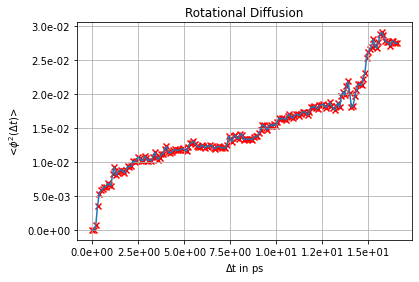

In [63]:
traj.plot_d_rot(rmsd, timestep=(traj.n_snapshots*0.0005))

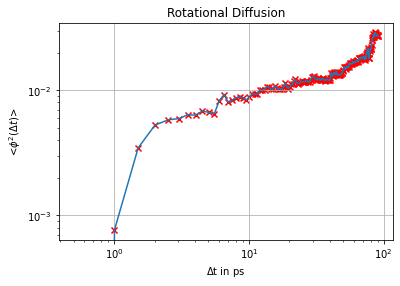

In [66]:
fig, ax = plt.subplots()

ax.scatter(0.0005*1000*np.linspace(0,len(rmsd), len(rmsd)), rmsd, color="red", marker="x")
ax.plot(0.0005*1000*np.linspace(0,len(rmsd), len(rmsd)), rmsd)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.set_xlabel("$\Delta$t in ps")
ax.grid()
ax.set_ylabel("<$\phi^2(\Delta t)$>")
ax.set_title("Rotational Diffusion")

plt.yscale("log")
plt.xscale("log")
plt.show()

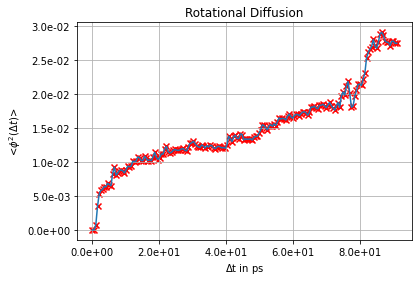

In [68]:
fig, ax = plt.subplots()

ax.scatter(0.0005*1000*np.linspace(0,len(rmsd), len(rmsd)), rmsd, color="red", marker="x")
ax.plot(0.0005*1000*np.linspace(0,len(rmsd), len(rmsd)), rmsd)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.set_xlabel("$\Delta$t in ps")
ax.grid()
ax.set_ylabel("<$\phi^2(\Delta t)$>")
ax.set_title("Rotational Diffusion")

plt.show()

In [47]:
traj2 = Trajectory("reduced_water.lammpstrj")
traj2.get_box_size()
traj2.s1, traj2.s2 = traj2.split_species()
print(traj2.s1)

Processing Snapshot:1
[array([[5.92600e+03, 1.00000e+00, 1.70260e-01, 2.87872e-01, 3.48330e-02],
       [1.16020e+04, 1.00000e+00, 1.25171e-01, 4.25715e-01, 2.22317e-01],
       [1.03470e+04, 1.00000e+00, 9.17387e-03, 4.11117e-01, 9.73607e-01],
       ...,
       [3.60300e+03, 1.00000e+00, 9.48402e-01, 5.29586e-01, 5.46967e-01],
       [3.60200e+03, 1.00000e+00, 9.20487e-01, 5.25505e-01, 5.50430e-01],
       [2.98300e+03, 1.00000e+00, 8.75902e-01, 5.02455e-01, 6.35631e-01]])]


In [48]:
traj2.indexlist, _ = traj2.get_neighbour_KDT(mode="pbc")

Atribute Error occured(recieved list instead of numpy array) using first element of list instead


In [49]:
traj2.get_displace(snapshot = 0, id = None, distance=0.5, eps=0.01, dp_factor = 0.99,
                     path=None, num_traj=None)

0.37333755555796955
distance too far next O
0.5706349544963049
distance too far next O
0.6039576722360931
distance too far next O
0.6157085454378963
distance too far next O
0.4741110273269332
distance too far next O
0.4269542310623001
distance too far next O
0.5898473724265032
distance too far next O
0.3018054030762206
distance too far next O
0.3816345303742837
distance too far next O
0.2249826956017951
distance too far next O
0.4943871787708496
displace
trajectory saved as water.data


In [19]:
traj.group_molecules(path="/home/ibrahimk95/Documents/n2p2_sims/working_files/new_ion_NN/recombination_5/")

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

In [25]:
traj.get_ion_distance()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [22]:
traj.remove_atoms(N=126)
#def remove_atoms(self, N=1, snap=0, atom_id=None, format_out="lammps"):

(128, 5) (256, 5)
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
(2, 5) (4, 5)
